Data sources:<br>
- https://github.com/BlankerL/DXY-COVID-19-Data
- https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports
- http://worldpopulationreview.com/countries/
- https://www.7continentslist.com/

References:<br>
- http://datav.aliyun.com/tools/atlas/#&lat=33.50475906922609&lng=104.32617187499999&zoom=4
- https://stackoverflow.com/questions/55106744/how-do-you-convert-shapely-multipolygon-to-polygon
- https://stackoverflow.com/questions/52812231/print-variable-in-jupyter-notebook-markdown-cell-python
- https://matplotlib.org/3.1.0/gallery/color/color_cycler.html#sphx-glr-gallery-color-color-cycler-py
- https://stackoverflow.com/questions/36104016/pandas-pivot-with-rows-and-columns-in-a-given-order

In [260]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.dates import DateFormatter

import geopandas
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement

In [2]:
# mac os
font_path = '/Library/Fonts/simhei.ttf'
fontP = font_manager.FontProperties(fname=font_path)
fontP.set_size(14)

fontP_medium = font_manager.FontProperties(fname=font_path)
fontP_medium.set_size(13)

fontP_small = font_manager.FontProperties(fname=font_path)
fontP_small.set_size(11)

In [3]:
data_df = pd.read_csv('DXYArea.csv')
data_supplement = pd.read_csv('DXYArea_supplement.csv')
data_df = data_df[data_df['provinceName'] != '西藏自治区']
data_df = pd.concat([data_df, data_supplement]).reset_index(drop=True)
pop18_df = pd.read_excel('population_2018.xlsx')

china_gdf = geopandas.read_file('china_geo.json', driver='JSON')
province_gdf = geopandas.read_file('province_geo.json', driver='JSON')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
data_df['updateTime'] = data_df.updateTime.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
data_df['Date_ymd'] = data_df['updateTime'].apply(lambda d: d.date())
data_df['Time_hms'] = data_df['updateTime'].apply(lambda d: d.time())

data_df = data_df.sort_values(by='updateTime')
data_df = data_df.reset_index(drop=True)

## Data cleaning

In [5]:
# 澳门特别行政区
data_df.loc[data_df['provinceName']=='澳门', 'provinceName'] = '澳门特别行政区'

# 上海市
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='嘉定'), 'cityName'] = '嘉定区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='奉贤'), 'cityName'] = '奉贤区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='宝山'), 'cityName'] = '宝山区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='徐汇'), 'cityName'] = '徐汇区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='杨浦'), 'cityName'] = '杨浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='松江'), 'cityName'] = '松江区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='虹口'), 'cityName'] = '虹口区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='金山'), 'cityName'] = '金山区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='长宁'), 'cityName'] = '长宁区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='闵行'), 'cityName'] = '闵行区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='青浦'), 'cityName'] = '青浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='静安'), 'cityName'] = '静安区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='黄浦'), 'cityName'] = '黄浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName'].isin(['浦东', '浦东区'])), 'cityName'] = '浦东新区'

# 云南省
data_df.loc[(data_df['provinceName']=='云南省') & (data_df['cityName']=='丽江市'), 'cityName'] = '丽江'
data_df.loc[(data_df['provinceName']=='云南省') & (data_df['cityName']=='西双版纳州'), 'cityName'] = '西双版纳'

# 内蒙古自治区
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='乌海'), 'cityName'] = '乌海市'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='通辽市经济开发区'), 'cityName'] = '通辽'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='呼和浩特（新城区）'), 'cityName'] = '呼和浩特'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='兴安盟乌兰浩特'), 'cityName'] = '兴安盟'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['包头市东河区', '包头市昆都仑区'])), 'cityName'] = '包头'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['赤峰市松山区', '赤峰市林西县'])), 'cityName'] = '赤峰'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['鄂尔多斯东胜区', '鄂尔多斯鄂托克前旗'])), 'cityName'] = '鄂尔多斯'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['锡林郭勒', '锡林郭勒盟二连浩特', '锡林郭勒盟锡林浩特'])), 'cityName'] = '锡林郭勒盟'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['满洲里', '呼伦贝尔满洲里', '呼伦贝尔牙克石', '呼伦贝尔牙克石市'])), 'cityName'] = '呼伦贝尔'

# 北京市
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='东城'), 'cityName'] = '东城区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='丰台'), 'cityName'] = '丰台区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='大兴'), 'cityName'] = '大兴区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='怀柔'), 'cityName'] = '怀柔区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='昌平'), 'cityName'] = '昌平区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='朝阳'), 'cityName'] = '朝阳区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='海淀'), 'cityName'] = '海淀区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='西城'), 'cityName'] = '西城区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='顺义'), 'cityName'] = '顺义区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='通州'), 'cityName'] = '通州区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='石景山'), 'cityName'] = '石景山区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='门头沟'), 'cityName'] = '门头沟区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='武汉来京人员'), 'cityName'] = '外地来京人员'

# 吉林省
data_df.loc[(data_df['provinceName']=='吉林省') & (data_df['cityName']=='吉林'), 'cityName'] = '吉林市'
data_df.loc[(data_df['provinceName']=='吉林省') & (data_df['cityName']=='四平市'), 'cityName'] = '四平'

# 四川省
data_df.loc[(data_df['provinceName']=='四川省') & (data_df['cityName']=='凉山'), 'cityName'] = '凉山州'

# 天津市
data_df.loc[(data_df['provinceName']=='天津市') & (data_df['cityName']=='宁河'), 'cityName'] = '宁河区'
data_df.loc[(data_df['provinceName']=='天津市') & (data_df['cityName']=='外地来津'), 'cityName'] = '外地来津人员'

# 宁夏回族自治区
data_df.loc[(data_df['provinceName']=='宁夏回族自治区') & (data_df['cityName']=='宁东'), 'cityName'] = '宁东管委会'

# 安徽省
data_df.loc[(data_df['provinceName']=='安徽省') & (data_df['cityName']=='歙县'), 'cityName'] = '黄山'
data_df.loc[(data_df['provinceName']=='安徽省') & (data_df['cityName']=='宿松'), 'cityName'] = '安庆'

# 山东省
data_df.loc[(data_df['provinceName']=='山东省') & (data_df['cityName']=='淄博市'), 'cityName'] = '淄博'

# 山西省
data_df.loc[(data_df['provinceName']=='山西省') & (data_df['cityName']=='临汾市'), 'cityName'] = '临汾'
data_df.loc[(data_df['provinceName']=='山西省') & (data_df['cityName']=='朔州市'), 'cityName'] = '朔州'

# 广东省
data_df.loc[(data_df['provinceName']=='广东省') & (data_df['cityName']=='河源市'), 'cityName'] = '河源'
data_df.loc[(data_df['provinceName']=='广东省') & (data_df['cityName']=='外地来穗人员'), 'cityName'] = '外地来粤人员'

# 新疆维吾尔自治区
data_df.loc[(data_df['provinceName']=='新疆维吾尔自治区') & (data_df['cityName']=='吐鲁番市'), 'cityName'] = '吐鲁番'
data_df.loc[(data_df['provinceName']=='新疆维吾尔自治区') &
            (data_df['cityName'].isin(['第七师', '第九师', '第八师', '第八师石河子', '第八师石河子市', '第六师'])),
            'cityName'] = '石河子'

# 江苏省
data_df.loc[(data_df['provinceName']=='江苏省') & (data_df['cityName']=='待明确'), 'cityName'] = '待明确地区'

# 河北省
data_df.loc[(data_df['provinceName']=='河北省') & (data_df['cityName']=='邯郸市'), 'cityName'] = '邯郸'

# 河南省
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='巩义'), 'cityName'] = '邓州'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='固始县'), 'cityName'] = '信阳'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='漯河市'), 'cityName'] = '漯河'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='鹤壁市'), 'cityName'] = '鹤壁'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['南阳（含邓州）', '邓州'])), 'cityName'] = '南阳'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['商丘（含永城）', '永城'])), 'cityName'] = '商丘'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['新乡（含长垣）', '长垣', '长垣县'])), 'cityName'] = '新乡'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['安阳市', '安阳（含滑县）', '滑县'])), 'cityName'] = '安阳'

# 海南省
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='东方市'), 'cityName'] = '东方'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='临高县'), 'cityName'] = '临高'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='澄迈县'), 'cityName'] = '澄迈'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='琼中县'), 'cityName'] = '琼中'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='琼海市'), 'cityName'] = '琼海'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='陵水县'), 'cityName'] = '陵水'

# 湖北省
data_df.loc[(data_df['provinceName']=='湖北省') & (data_df['cityName']=='恩施'), 'cityName'] = '恩施州'

# 甘肃省
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='天水市'), 'cityName'] = '天水'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='平凉市'), 'cityName'] = '平凉'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='白银市'), 'cityName'] = '白银'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='金昌市'), 'cityName'] = '金昌'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']==''), 'cityName'] = ''

# 重庆市
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='丰都'), 'cityName'] = '丰都县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='云阳'), 'cityName'] = '云阳县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='垫江'), 'cityName'] = '垫江县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='城口'), 'cityName'] = '城口县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='奉节'), 'cityName'] = '奉节县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='巫山'), 'cityName'] = '巫山县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='巫溪'), 'cityName'] = '巫溪县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='石柱'), 'cityName'] = '石柱县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='秀山'), 'cityName'] = '秀山县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='酉阳县'), 'cityName'] = '酉阳'

# 青海省
data_df.loc[(data_df['provinceName']=='青海省') & (data_df['cityName']=='西宁市'), 'cityName'] = '西宁'
data_df.loc[(data_df['provinceName']=='青海省') & (data_df['cityName']=='北海州'), 'cityName'] = '海北州'


In [6]:
# http://www.gxzf.gov.cn/mlgx/gxrw/qhrk/20170331-486083.shtml
pop18_df.loc[len(pop18_df), 'provinceName'] = '广西壮族自治区'
pop18_df.loc[pop18_df['provinceName'] == '广西壮族自治区', 'population_2018'] = 56590000

pop18_df.loc[len(pop18_df), 'provinceName'] = '宁夏回族自治区'
pop18_df.loc[pop18_df['provinceName'] == '宁夏回族自治区', 'population_2018'] = 56881100

In [7]:
province_daily_last = data_df.groupby(['provinceName', 'Date_ymd'])['Time_hms'].max().reset_index()

for i, cols in province_daily_last.iterrows():
    province_daily_last.loc[i, 'province_confirmedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_confirmedCount'].unique()[0]
    province_daily_last.loc[i, 'province_suspectedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_suspectedCount'].unique()[0]
    province_daily_last.loc[i, 'province_curedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_curedCount'].unique()[0]
    province_daily_last.loc[i, 'province_deadCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_deadCount'].unique()[0]

province_daily_last = province_daily_last.sort_values(by=['provinceName', 'Date_ymd'])
province_daily_last = province_daily_last.reset_index(drop=True)

In [9]:
city_daily_last = data_df.groupby(['provinceName', 'cityName', 'Date_ymd'])['Time_hms'].max().reset_index()

for i, cols in city_daily_last.iterrows():
    city_daily_last.loc[i, 'city_confirmedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                            (data_df['cityName'] == cols['cityName']) &
                                                            (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                            (data_df['Time_hms'] == cols['Time_hms'])]['city_confirmedCount'].values[0]
    city_daily_last.loc[i, 'city_suspectedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                            (data_df['cityName'] == cols['cityName']) &
                                                            (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                            (data_df['Time_hms'] == cols['Time_hms'])]['city_suspectedCount'].values[0]
    city_daily_last.loc[i, 'city_curedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                        (data_df['cityName'] == cols['cityName']) &
                                                        (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                        (data_df['Time_hms'] == cols['Time_hms'])]['city_curedCount'].values[0]
    city_daily_last.loc[i, 'city_deadCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                       (data_df['cityName'] == cols['cityName']) &
                                                       (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                       (data_df['Time_hms'] == cols['Time_hms'])]['city_deadCount'].values[0]
    
city_daily_last['pcName'] = city_daily_last['provinceName'] + '-' + city_daily_last['cityName']


## Whole China

### Data preparation

In [10]:
def calcul_percentage(numerator, denominator):
    if denominator == 0:
        return numerator * 100
    else:
        return numerator/denominator * 100

In [11]:
# Daily confirmed count per province (complet missing dates)
province_daily_cfirmed_pvt = pd.pivot_table(data=province_daily_last,
                                            index='Date_ymd',
                                            columns='provinceName',
                                            values='province_confirmedCount',
                                            fill_value=0)
province_daily_cfirmed_pvt = province_daily_cfirmed_pvt.reset_index()

for i, v in province_daily_cfirmed_pvt.iterrows():
    for col in province_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_cfirmed_pvt.loc[i, col] = province_daily_cfirmed_pvt.loc[i-1, col]

province_daily_cfirmed_pvt.index = province_daily_cfirmed_pvt.Date_ymd

province_daily_cfirmed_df = province_daily_cfirmed_pvt.stack()
province_daily_cfirmed_df = province_daily_cfirmed_df.to_frame().reset_index()
province_daily_cfirmed_df = province_daily_cfirmed_df[
    province_daily_cfirmed_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_cfirmed_df.columns = ['Date_ymd', 'provinceName', 'province_confirmedCount']

In [12]:
# Daily cured count per province (complet missing dates)
province_daily_cured_pvt = pd.pivot_table(data=province_daily_last,
                                          index='Date_ymd',
                                          columns='provinceName',
                                       values='province_curedCount',
                                       fill_value=0)
province_daily_cured_pvt = province_daily_cured_pvt.reset_index()

for i, v in province_daily_cured_pvt.iterrows():
    for col in province_daily_cured_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_cured_pvt.loc[i, col] = province_daily_cured_pvt.loc[i-1, col]

province_daily_cured_pvt.index = province_daily_cured_pvt.Date_ymd

province_daily_cured_df = province_daily_cured_pvt.stack()
province_daily_cured_df = province_daily_cured_df.to_frame().reset_index()
province_daily_cured_df = province_daily_cured_df[
    province_daily_cured_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_cured_df.columns = ['Date_ymd', 'provinceName', 'province_curedCount']

In [13]:
# Daily dead count per province (complet missing dates)
province_daily_dead_pvt = pd.pivot_table(data=province_daily_last,
                                      index='Date_ymd',
                                      columns='provinceName',
                                      values='province_deadCount',
                                      fill_value=0)
province_daily_dead_pvt = province_daily_dead_pvt.reset_index()

for i, v in province_daily_dead_pvt.iterrows():
    for col in province_daily_dead_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_dead_pvt.loc[i, col] = province_daily_dead_pvt.loc[i-1, col]

province_daily_dead_pvt.index = province_daily_dead_pvt.Date_ymd

province_daily_dead_df = province_daily_dead_pvt.stack()
province_daily_dead_df = province_daily_dead_df.to_frame().reset_index()
province_daily_dead_df = province_daily_dead_df[
    province_daily_dead_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_dead_df.columns = ['Date_ymd', 'provinceName', 'province_deadCount']

In [14]:
province_daily_df = pd.merge(province_daily_cfirmed_df,
                             province_daily_cured_df,
                             on=['Date_ymd', 'provinceName'])
province_daily_df = pd.merge(province_daily_df,
                             province_daily_dead_df,
                             on=['Date_ymd', 'provinceName'])

In [15]:
china_daily_last = province_daily_df.groupby(['Date_ymd'])['province_confirmedCount',
                                                           'province_curedCount',
                                                           'province_deadCount'].sum()

china_daily_last['mortality_pct'] = china_daily_last.apply(lambda row:calcul_percentage(
    row['province_deadCount'], row['province_confirmedCount']), axis='columns')

china_daily_last['cured_pct'] = china_daily_last.apply(lambda row:calcul_percentage(
    row['province_curedCount'], row['province_confirmedCount']), axis='columns')

china_daily_last['province_confirmedCount_new'] = china_daily_last['province_confirmedCount'].diff()
china_daily_last['province_confirmedCount_deltaRate'] = \
china_daily_last['province_confirmedCount_new'].pct_change() * 100
china_daily_last['province_act_confirmedCount'] = \
china_daily_last['province_confirmedCount'] - china_daily_last['province_curedCount'] - china_daily_last['province_deadCount']
china_daily_last = china_daily_last.fillna(0)

### Confirmed count

In [16]:
DATESFMT = DateFormatter('%m-%d')

In [17]:
def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def thousands_1dec(x, pos):
    return '%1.1f' % (x * 1e-3)

def millions(x, pos):
    return '%1.0f' % (x * 1e-6)

formatter_thousands = FuncFormatter(thousands)
formatter_thousands_1dec = FuncFormatter(thousands_1dec)
formatter_millions = FuncFormatter(millions)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


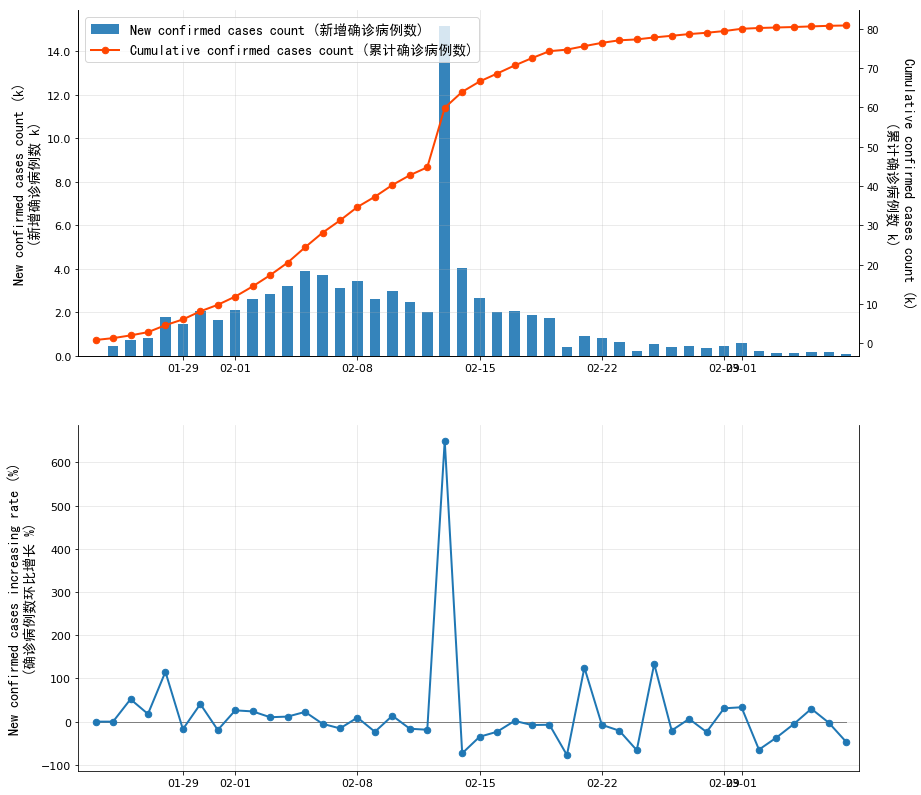

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

# above
bar_new_cfirmed = ax[0].bar(china_daily_last.index,
                            china_daily_last['province_confirmedCount_new'],
                            alpha=0.9,
                            width=0.6)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('New confirmed cases count (k)\n(新增确诊病例数 k)', size=12, fontproperties=fontP)
ax[0].yaxis.set_major_formatter(formatter_thousands_1dec)
ax[0].grid(which='major', alpha=0.3)
ax[0].spines['top'].set_visible(False)

ax_02 = ax[0].twinx()
line_cfirmed, = ax_02.plot(china_daily_last.index,
                           china_daily_last['province_confirmedCount'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.set_ylabel('Cumulative confirmed cases count (k)\n(累计确诊病例数 k)', rotation=270,
                 labelpad=35, size=12, fontproperties=fontP)
ax_02.xaxis.set_major_formatter(DATESFMT)
ax_02.yaxis.set_major_formatter(formatter_thousands)

ax_02.legend(handles=(bar_new_cfirmed, line_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('New confirmed cases count (新增确诊病例数)',
                     'Cumulative confirmed cases count (累计确诊病例数)'),
             loc=2)
ax_02.spines['top'].set_visible(False)

# below
ax[1].plot(china_daily_last.index,
           [0] * len(china_daily_last),
           color='gray', linewidth=1)
line_delta, = ax[1].plot(china_daily_last.index,
                         china_daily_last['province_confirmedCount_deltaRate'],
                         linewidth=2,
                         marker='.',
                         markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.3)
ax[1].spines['top'].set_visible(False)


# plt.show()
# plt.savefig('20200302_china_confirmed_cases.png', bbox_inches='tight')

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国累计确诊新冠肺炎病例约{{china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount']}}例，较前一天增长{{int(china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount_new'])}}例。需要注意的是，2020年2月5日的新增确诊病例量达到顶峰，如果按7-14天潜伏期来算，说明在1月24日与1月29日之间，感染新冠并处于潜伏期的人偏多。此时正值中国新年假期，人们走亲访友可能成为被传染的一个因素。但随后每日新增确诊人数开始下降，环比确诊数也下降到+/-20%，可以反映出1月底人们防范意识开始加强，降低了被传染的可能性。

2020年2月13日，由于湖北省诊断标准更改，新增确诊数大大增加。按原有诊断标准，疑似病例且进行核酸/基因测序检查结果为阳性者被视为新增确诊病例；更改后的诊断标准添加了临床诊断病例，所谓临床诊断病例，是指疑似病例具有肺炎影像学特征者，也就是说，只要符合疑似标准，且有CT特征，即可被视为新增确诊病例，不再需要进行核酸检测。

2020年2月21日，三省五个监狱发现疫情：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。监狱系统确诊病例爆发，原因可能是以下三个方面：一、前期防控不足，对密切接触者、疑似人员没有做到“早发现、早隔离、早治疗”；二、在封闭的环境中更容易造成疾病的大范围传播；三、在相关人员（如狱警）确诊后，监狱马上开展了集中的大范围排查，一次性确诊了较多病例。(https://mama.dxy.com/outbreak/daily-of-nationwide-new?index=20200221&locationIds=999&from=todh5)

--- English version ---

As of 24:00 Beijing time on {{china_daily_last.index[-1].day}}/{{china_daily_last.index[-1].month}}/{{china_daily_last.index[-1].year}}, China has cumulatively diagnosed about {{china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount']}} confirmed cases of coronavirus, an increase of {{int(china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount_new'])}} over the previous day. It should be noted that the number of newly confirmed cases on February 5, 2020 reached its peak. If our calculation is based on the 7-14 days' incubation period, it means that between January 24 and January 29, people who were infected and were in the incubation period are a little bit more. It was exactly the Chinese New Year holiday, people visited relatives and friends may become a factor of infection. However, the number of newly confirmed cases started to decline daily, and the number of confirmed cases dropped to +/- 20% from the previous day, which can reflect that people's awareness of prevention began to strengthen at the end of January, which reduces the possibility of infection.

On February 13, 2020, the number of newly confirmed cases increased significantly due to changes in diagnostic standards in Hubei Province. According to the original diagnostic criteria, suspected cases and positive results of nucleic acid / gene sequencing are considered as newly confirmed cases; the updated diagnostic criteria added clinical diagnosis cases. The so-called clinical diagnosis cases refer to the suspected cases with pneumonia imaging features, that is, as long as they meet the suspected criteria and have CT features, they can be regarded as newly confirmed cases, and no nucleic acid test is required.

On February 21, 2020, outbreaks were found in five prisons in three provinces: 230 cases were confirmed in Wuhan Women's Prison (Wuhan), 1 case was suspected by Hubei Province Juvenile Delinquent (Wuhan), and 41 cases were confirmed in Shayang Hanjin Prison (Jingmen). Nine cases were suspected, 200 cases were confirmed by Rencheng Prison (Jining), 10 cases were suspected, and 34 cases were confirmed by Shilifeng Prison (Luzhou). The outbreak of confirmed cases in the prison system may be due to the following three aspects: 1. Inadequate pre-control and lack of "early detection, early isolation, and early treatment" of close contacts and suspects; 2. virus is more likely to spread widely in a closed environment; 3. After the relevant personnel (such as prison guards) being confirmed, the prison immediately launched a large-scale investigation and confirmed many cases at the same time.

### Cured count vs. Dead count

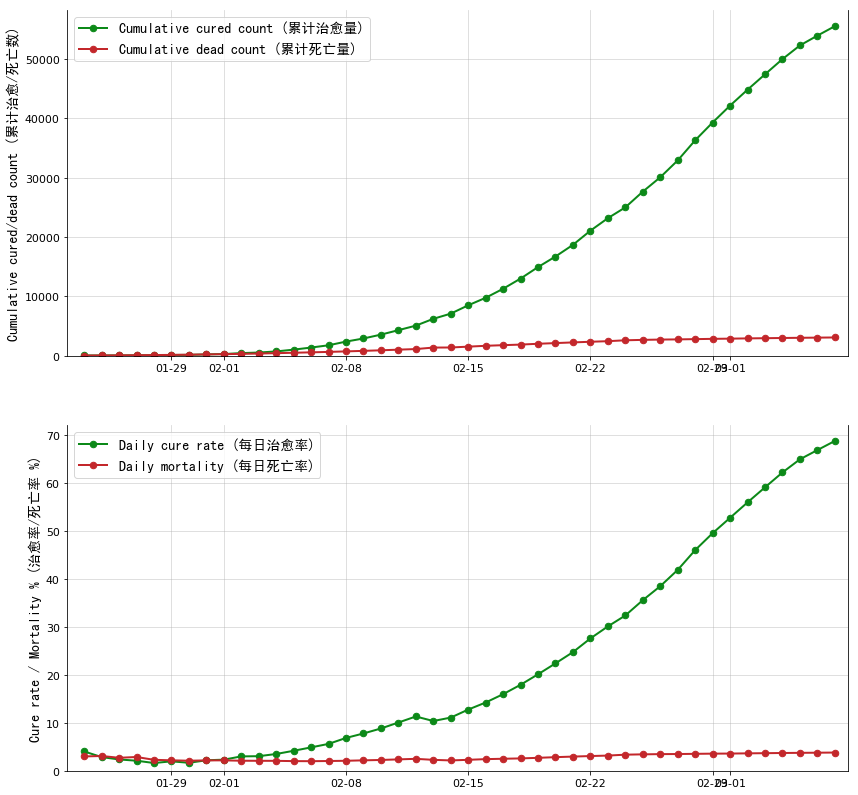

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

line_cured, = ax[0].plot(china_daily_last.index,
                      china_daily_last['province_curedCount'],
                      color='#0c8918', # green
                      linewidth=2,
                      marker='.',
                      markersize=13)

line_dead, = ax[0].plot(china_daily_last.index,
                     china_daily_last['province_deadCount'],
                     color='#c3272b', # red
                     linewidth=2,
                     marker='.',
                     markersize=13)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylim(bottom=0)
ax[0].set_ylabel('Cumulative cured/dead count (累计治愈/死亡数)', size=12, fontproperties=fontP)

ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].grid(which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax[0].legend(handles=(line_cured, line_dead),
             fontsize=13,
             prop=fontP,
             labels=('Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=2)

line_cure_rate, = ax[1].plot(china_daily_last.index,
                                 china_daily_last['cured_pct'],
                                 color='#0c8918',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)
line_mortality_pct, = ax[1].plot(china_daily_last.index,
                                 china_daily_last['mortality_pct'],
                                 color='#c3272b',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylim(bottom=0)
ax[1].set_ylabel('Cure rate / Mortality % (治愈率/死亡率 %)', size=12, fontproperties=fontP)

ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)

ax[1].legend(handles=(line_cure_rate, line_mortality_pct),
             fontsize=13,
             prop=fontP,
             labels=('Daily cure rate (每日治愈率)',
                     'Daily mortality (每日死亡率)'), loc=2)

# plt.show()
# plt.savefig('20200302_china_cure_mortality.png', bbox_inches='tight')

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国累计治愈新冠肺炎病例{{china_daily_last.loc[china_daily_last.index[-1], 'province_curedCount']}}例，累计死亡新冠肺炎病例{{china_daily_last.loc[china_daily_last.index[-1], 'province_deadCount']}}例。自2020年1月31日起，中国新冠肺炎病例治愈数量和治愈率超过死亡数量和死亡率，且差值越来越大，目前已达到{{round(china_daily_last.loc[china_daily_last.index[-1], 'cured_pct'], 2)}}%。这和医务人员的不懈努力是分不开的。

--- English version ---

As of 24:00 Beijing time on {{china_daily_last.index[-1].day}}/{{china_daily_last.index[-1].month}}/{{china_daily_last.index[-1].year}}, China has accumulatively cured {{china_daily_last.loc[china_daily_last.index[-1], 'province_curedCount']}} cases of coronavirus and accumulated {{china_daily_last.loc[china_daily_last.index[-1], 'province_deadCount']}} cases of deaths. Since January 31, 2020, the number of cured cases and the cure rate of new cases of pneumonia in China have exceeded the number of deaths and death rates, and the difference is getting larger and larger, currently reaching {{round(china_daily_last.loc[china_daily_last.index[-1], 'cured_pct'], 2)}}%. This is inseparable from the tireless efforts of medical staff.

## Per province

### Actual confirmed count

In [20]:
province_last_df = province_daily_df[province_daily_df['Date_ymd'] == province_daily_df['Date_ymd'].max()]
province_last_df = province_last_df.reset_index(drop=True)
province_last_df['province_act_confirmedCount'] = \
province_last_df['province_confirmedCount'] - province_last_df['province_curedCount'] - province_last_df['province_deadCount']

In [21]:
province_last_geo = pd.merge(province_last_df,
                             province_gdf[['name', 'geometry']],
                             left_on='provinceName',
                             right_on='name')
province_last_geo = province_last_geo.drop(columns='name')
province_last_geo = province_last_geo.dropna()

In [22]:
crs = {'init': 'epsg:4326'}
province_last_gdf = geopandas.GeoDataFrame(province_last_geo, crs=crs)

In [23]:
template_province = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 20px;'>
     
<div class='legend-title'>Confirmed count<br>(确诊数量)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>1 - 9</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>10 - 99</li>
    <li><span style='background:#e86558;opacity:1;'></span>100 - 499</li>
    <li><span style='background:#d13035;opacity:1;'></span>500 - 999</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>1000 - 10000</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 10000</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [24]:
template_province_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Confirmed count per province (各省、直辖市、自治区确诊数量)</div>
<div class='legend-scale'><font size="3">China (中国) / Per province (各省、直辖市、自治区) / 2020-03-07</font></div>
</div>

</body>
</html>

{% endmacro %}"""

In [25]:
province_map = folium.Map(location=[36.130926, 106.925774],
                          zoom_start=4, tiles='cartodbpositron')

colormap_province = cm.StepColormap(
    colors=['#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_last_gdf['province_act_confirmedCount']),
    vmax=max(province_last_gdf['province_act_confirmedCount']),
    index=[1, 9, 99, 499, 999, 10000, 100000000])

style_function = lambda x: {
    'fillColor': colormap_province(x['properties']['province_act_confirmedCount']),
    'color': '',
    'weight': 0.0001,
    'fillOpacity': 1
}

folium.GeoJson(
    province_last_gdf[province_last_gdf['province_act_confirmedCount']>0][['provinceName', 'province_act_confirmedCount', 'geometry']],
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
            fields=['provinceName', 'province_act_confirmedCount'],
            aliases=['Province', 'Actual confirmed count'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_last_gdf[province_last_gdf['province_act_confirmedCount']==0][['provinceName', 'province_act_confirmedCount', 'geometry']],
    style_function = lambda x: {
        'color': 'white',
        'fillOpacity': 1
    },
    tooltip=folium.GeoJsonTooltip(
            fields=['provinceName', 'province_act_confirmedCount'],
            aliases=['Province', 'Actual confirmed count'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_map)

macro = MacroElement()
macro._template = Template(template_province)
macro2 = MacroElement()
macro2._template = Template(template_province_title)
province_map.get_root().add_child(macro)
province_map.get_root().add_child(macro2)


In [26]:
province_map.save('province_map.html')

### Map in time series

In [27]:
province_daily_ts = province_daily_df.copy()

province_daily_ts['province_act_confirmedCount'] = \
province_daily_ts['province_confirmedCount'] - province_daily_ts['province_curedCount'] - province_daily_ts['province_deadCount']
province_daily_ts = province_daily_ts.fillna(0)
province_daily_ts = province_daily_ts.sort_values(['provinceName', 'Date_ymd']).reset_index(drop=True)

province_daily_ts_geo = pd.merge(province_daily_ts,
                                 province_gdf[['name', 'geometry']],
                                 left_on='provinceName',
                                 right_on='name',
                                 how='left')
province_daily_ts_geo = province_daily_ts_geo[['provinceName', 'geometry']]
province_daily_ts_geo = province_daily_ts_geo.drop_duplicates('provinceName').reset_index(drop=True)


In [28]:
datetime_index = pd.DatetimeIndex(province_daily_ts.Date_ymd.unique())

dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = np.array(dt_index_epochs).astype('U10')

In [29]:
styledata = {}

s = 0
e = province_daily_ts.Date_ymd.nunique()
for i, v in province_daily_ts_geo.iterrows():
    df = pd.DataFrame(
        {'color': np.array(province_daily_ts.province_act_confirmedCount[s:e]),
         'opacity': np.array([1] * province_daily_ts.Date_ymd.nunique())},
        index=dt_index
    )
    styledata[i] = df
    s += province_daily_ts.Date_ymd.nunique()
    e += province_daily_ts.Date_ymd.nunique()

In [30]:
max_opacity, min_opacity = 1, 1

colormap_province = cm.StepColormap(
    colors=['#ffffff', '#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_last_gdf['province_act_confirmedCount']),
    vmax=max(province_last_gdf['province_act_confirmedCount']),
    index=[0, 0.9, 9, 99, 499, 999, 10000, 100000000])

for i, data in styledata.items():
    data['color'] = data['color'].map(colormap_province)
    data['opacity'] = 1

In [31]:
styledict = {
    str(nb): data.to_dict(orient='index') for nb, data in styledata.items()
}

In [32]:
template_choropleth = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 90px;'>
     
<div class='legend-title'>Confirmed count<br>(确诊数量)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>1 - 9</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>10 - 99</li>
    <li><span style='background:#e86558;opacity:1;'></span>100 - 499</li>
    <li><span style='background:#d13035;opacity:1;'></span>500 - 999</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>1000 - 10000</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 10000</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""



In [33]:
crs = {'init': 'epsg:4326'}
province_daily_ts_gdf = geopandas.GeoDataFrame(province_daily_ts_geo, crs=crs)

from folium.plugins import TimeSliderChoropleth

province_actual_confirmed_history_map = folium.Map(location=[36.130926, 106.925774],
                                                   zoom_start = 4, tiles='cartodbpositron')

TimeSliderChoropleth(
    province_daily_ts_gdf.to_json(),
    styledict=styledict
).add_to(province_actual_confirmed_history_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_actual_confirmed_history_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_actual_confirmed_history_map)

macro = MacroElement()
macro._template = Template(template_choropleth)
province_actual_confirmed_history_map.get_root().add_child(macro)

province_actual_confirmed_history_map

In [34]:
province_actual_confirmed_history_map.save('province_actual_confirmed_history_map.html')

### Hubei vs. other provinces

In [35]:
province_last_sorted_df = province_last_df.copy()
province_last_sorted_df = province_last_sorted_df.sort_values(by='province_act_confirmedCount',
                                                              ascending=False).reset_index(drop=True)

**Cumulative confirmed count (Hubei vs. other provinces)**

In [36]:
hubei_last_sorted_df = province_last_sorted_df[
    province_last_sorted_df['provinceName'] == '湖北省'].reset_index(drop=True)

not_hubei_last_sorted_df = province_last_sorted_df[
    province_last_sorted_df['provinceName'] != '湖北省'].reset_index(drop=True)
not_hubei_last_tot = not_hubei_last_sorted_df.groupby(['Date_ymd'])['province_act_confirmedCount',
                                                                    'province_curedCount',
                                                                    'province_deadCount'].sum().reset_index()
not_hubei_last_tot.insert(loc=1, column='provinceName', value='非湖北省')

hubei_vs_others_last_df = pd.concat([hubei_last_sorted_df, not_hubei_last_tot])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [37]:
# Hubei vs others: confirmed count, cured rate & mortality
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_confirmedCount'] = \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_act_confirmedCount'] + \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_curedCount'] + \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_deadCount']

hubei_vs_others_last_df['cured_pct'] = \
hubei_vs_others_last_df['province_curedCount'] / hubei_vs_others_last_df['province_confirmedCount']
hubei_vs_others_last_df['mortality_pct'] = \
hubei_vs_others_last_df['province_deadCount'] / hubei_vs_others_last_df['province_confirmedCount']

In [38]:
# Not Hubei: cured rate & mortality
not_hubei_last_sorted_df['cured_pct'] = \
not_hubei_last_sorted_df['province_curedCount'] / not_hubei_last_sorted_df['province_confirmedCount']
not_hubei_last_sorted_df['mortality_pct'] = \
not_hubei_last_sorted_df['province_deadCount'] / not_hubei_last_sorted_df['province_confirmedCount']

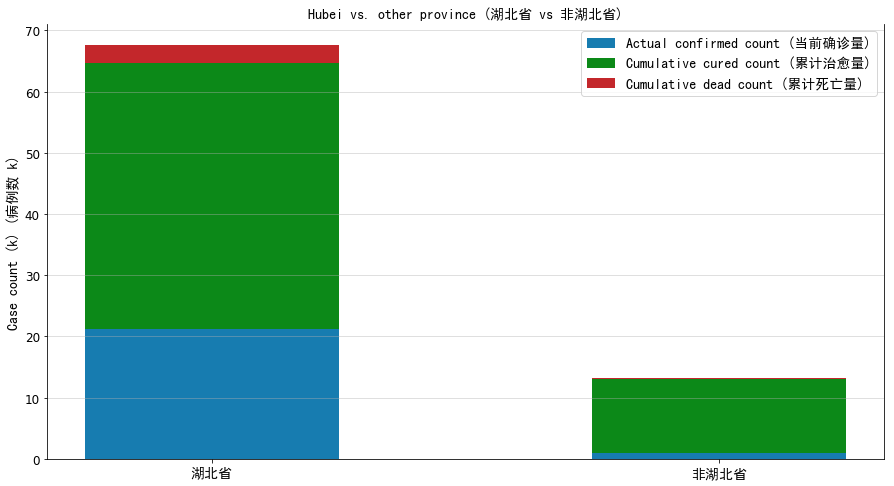

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

# Hubei vs. other province
ax.set_title('Hubei vs. other province (湖北省 vs 非湖北省)', fontdict={'fontsize': 14}, fontproperties=fontP)
rect01 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_act_confirmedCount,
                   color='#177cb0',
                   width=0.5)
rect02 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_curedCount,
                   bottom=hubei_vs_others_last_df.province_act_confirmedCount,
                   color='#0c8918',
                   width=0.5)
rect03 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_deadCount,
                   bottom=hubei_vs_others_last_df.province_act_confirmedCount + hubei_vs_others_last_df.province_curedCount,
                   color='#c3272b',
                   width=0.5)

ax.tick_params(labelsize=12)
ax.set_xticklabels(hubei_vs_others_last_df.provinceName, fontproperties=fontP)
ax.set_ylabel('Case count (k) (病例数 k)', size=12, fontproperties=fontP)
ax.yaxis.set_major_formatter(formatter_thousands)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', which='major', alpha=0.5)

ax.legend(handles=(rect01, rect02, rect03),
             fontsize=12,
             prop=fontP,
             labels=('Actual confirmed count (当前确诊量)',
                     'Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=1)

# plt.show()
# plt.savefig('20200302_province_confirmed_cases.png', bbox_inches='tight')

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国各省（直辖市、自治区）中湖北省确诊病例最多，累计高达{{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'province_confirmedCount'][0]}}例，远超其余省份确诊数量之和（{{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'province_confirmedCount'][0]}}）；湖北省治愈率为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'cured_pct'][0] * 100, 1)}}%，其余省份为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'cured_pct'][0] * 100, 1)}}%；湖北省新冠肺炎死亡率为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'mortality_pct'][0] * 100, 1)}}%，其余省份为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'mortality_pct'][0] * 100, 1)}}%。

--- English version ---

As of 24:00 Beijing time on {{china_daily_last.index[-1].day}}/{{china_daily_last.index[-1].month}}/{{china_daily_last.index[-1].year}}, Hubei Province has the largest number of confirmed cases in all provinces (municipalities and autonomous regions) in China, with a cumulative total of {{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'province_confirmedCount'][0]}} cases, far exceeding the sum of the confirmed number of other provinces ({{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'province_confirmedCount'][0]}}); the cure rate in Hubei Province is {{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'cured_pct'][0] * 100, 1)}}%, the remaining provinces accounted for {{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'cured_pct'][0] * 100, 1)}}%; Hubei Province had a coronavirus' mortality rate of {{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'mortality_pct'][0] * 100, 1)}}%, and the remaining provinces were {{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'mortality_pct'][0] * 100, 1)}}%.

In [40]:
hubei_vs_others_last_df

Date_ymd provinceName province_act_confirmedCount  \
0  2020-03-07          湖北省                       21207   
0  2020-03-07         非湖北省                         989   

  province_confirmedCount province_curedCount province_deadCount cured_pct  \
0                   67666               43500               2959  0.642863   
0                   13149               12046                114  0.916115   

  mortality_pct  
0     0.0437295  
0    0.00866986

**Cumulative confirmed count per province (not Hubei)**

In [41]:
pop_sorted_cfirmedCnt = pd.merge(province_last_sorted_df[['provinceName']], pop18_df,
                                 on='provinceName', how='left')

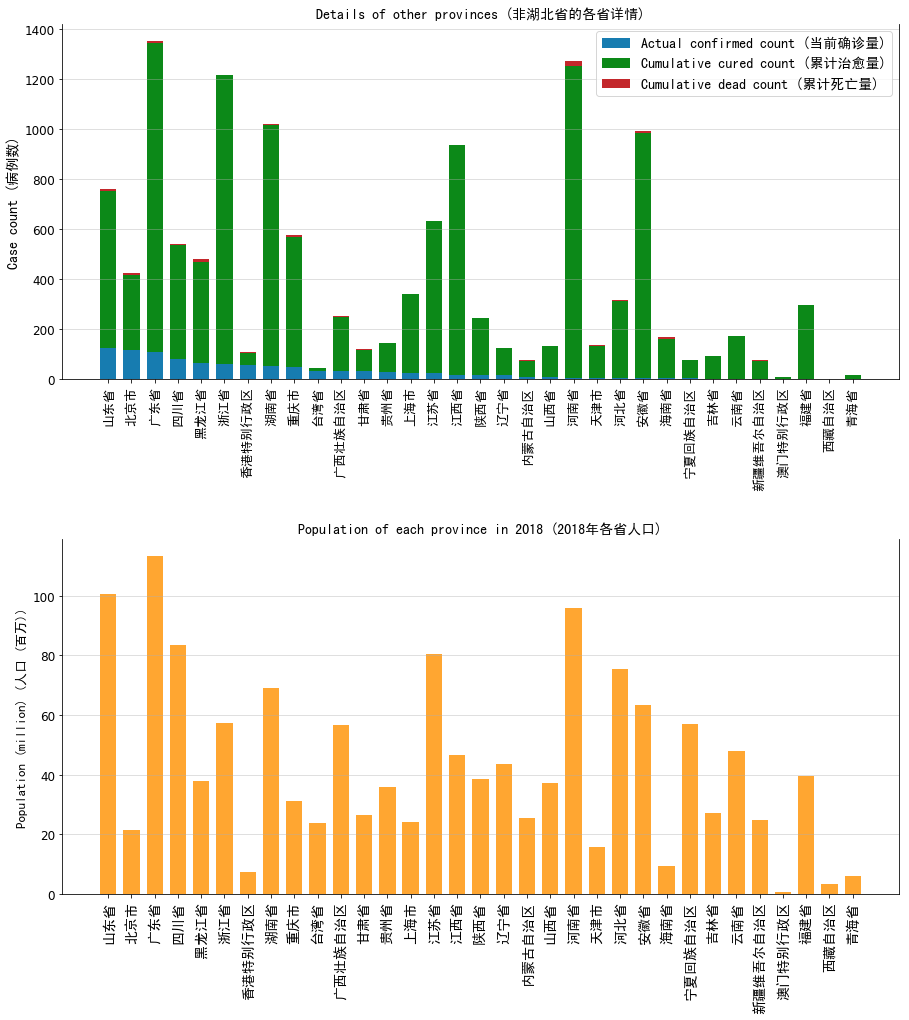

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Details of other provinces
ax[0].set_title('Details of other provinces (非湖北省的各省详情)', fontdict={'fontsize': 14}, fontproperties=fontP)
rect11 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_act_confirmedCount,
                   color='#177cb0',
                   width=0.7)
rect12 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_curedCount,
                   bottom=not_hubei_last_sorted_df.province_act_confirmedCount,
                   color='#0c8918',
                   width=0.7)
rect13 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_deadCount,
                   bottom=not_hubei_last_sorted_df.province_act_confirmedCount + not_hubei_last_sorted_df.province_curedCount,
                   color='#c3272b',
                   width=0.7)

ax[0].tick_params(labelsize=12)
ax[0].set_xticklabels(not_hubei_last_sorted_df.provinceName, rotation=90, fontproperties=fontP_medium)
ax[0].set_ylabel('Case count (病例数)', fontproperties=fontP)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', which='major', alpha=0.5)

ax[0].legend(handles=(rect11, rect12, rect13),
             prop=fontP,
             labels=('Actual confirmed count (当前确诊量)',
                     'Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=1)

# Population of each province
ax[1].set_title('Population of each province in 2018 (2018年各省人口)',
                fontdict={'fontsize': 14}, fontproperties=fontP)
ax[1].bar(pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].provinceName,
          pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].population_2018,
          color='#ffa631',
          width=0.7)

ax[1].tick_params(labelsize=12)
ax[1].set_xticklabels(pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].provinceName,
                      rotation=90, fontproperties=fontP)
ax[1].set_ylabel('Population (million) (人口 (百万))', size=12, fontproperties=fontP_medium)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].yaxis.set_major_formatter(formatter_millions)

plt.subplots_adjust(hspace=0.45)
# plt.show()
# plt.savefig('20200302_province_details_confirmed_cases.png', bbox_inches='tight')

上图省份按照现存确诊数降序排列。除湖北省，广东省、河南省和浙江省，累计确诊均多于1000例，对照2018年人口数据，人口多、人员流动性强也许是其中一个原因；西藏自治区于2020年1月29日出现1例确诊，且该患者已于2月12日被治愈出院；2月21日10时20分，青海省最后2例新冠肺炎病例从青海省第四人民医院出院。至此，青海收住在青海省第四人民医院的15例确诊病例全部出院，加之前期收住在西宁市第三人民医院已经出院的3例确诊病例，青海18例确诊病例全部出院。西藏自治区和青海省目前为中国唯一两个零确诊病例的省（直辖市、自治区）。

https://m.weibo.cn/status/4474349975557803?

--- English version ---

The provinces above are listed in descending order of the number of confirmed cases. Except for Hubei Province, Guangdong Province, Henan Province and Zhejiang Province, the cumulative cases was more than 1000 cases. Compared with the 2018 population data, the large population and strong mobility may be one of the reasons. One case was confirmed in Tibet Autonomous Region on January 29, 2020, and the patient was cured and discharged on February 12; at 10:20 on February 21, the last 2 cases of coronavirus in Qinghai Province were discharged from the Fourth People's Hospital of Qinghai Province. So far, all 18 confirmed cases in Qinghai Province have been discharged. The Tibet Autonomous Region and Qinghai Province are currently the only two provinces (municipalities and autonomous regions) in China with zero confirmed cases.

**Cured rate & mortality per province**

In [43]:
# Each province: cured rate & mortality
province_last_sorted_df['cured_pct'] = \
province_last_sorted_df['province_curedCount'] / province_last_sorted_df['province_confirmedCount'] *100
province_last_sorted_df['mortality_pct'] = \
province_last_sorted_df['province_deadCount'] / province_last_sorted_df['province_confirmedCount'] * 100

province_last_sorted_df['province_confirmedCount'] = province_last_sorted_df['province_confirmedCount'].astype(int)
province_last_sorted_df['province_curedCount'] = province_last_sorted_df['province_curedCount'].astype(int)
province_last_sorted_df['province_deadCount'] = province_last_sorted_df['province_deadCount'].astype(int)
province_last_sorted_df['cured_pct'] = province_last_sorted_df['cured_pct'].astype(float)
province_last_sorted_df['mortality_pct'] = province_last_sorted_df['mortality_pct'].astype(float)

In [44]:
province_colors = ['#9d2933', '#c83c23', '#be002f', '#ff2121', '#db5a6b', '#ff7500', '#ff8936',
                   '#ffa631', '#fff143', '#eaff56', '#f0c239', '#d9b611', '#bce672', '#afdd22',
                   '#00bc12', '#0c8918', '#40de5a', '#00e079', '#3de1ad', '#48c0a3', '#70f3ff',
                   '#44cef6', '#177cb0', '#065279', '#4b5cc4', '#8d4bbb', '#815463', '#b0a4e3',
                   '#cca4e3', '#edd1d8', '#88ada6', '#f3d3e7', '#d4f2e7', '#eedeb0']

Text(0.35537558416262427, 40, 'Average mortality = 1.2')

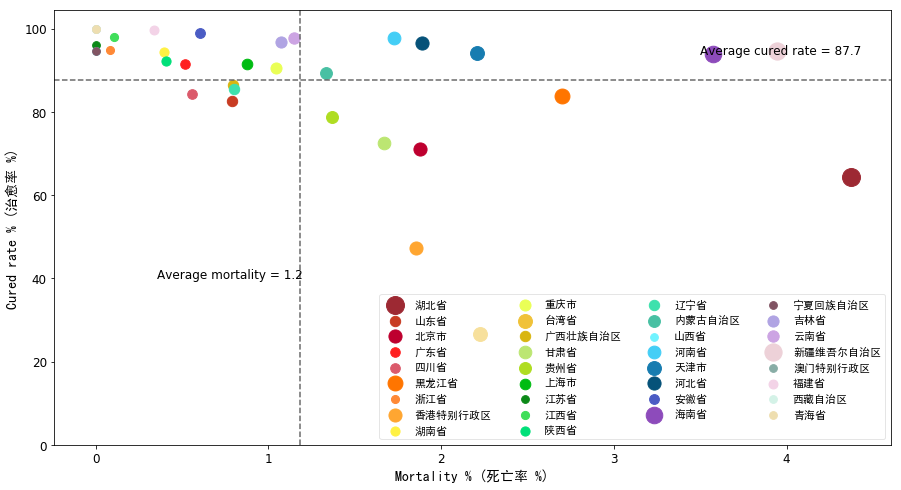

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.set_prop_cycle(color=province_colors)
for i, rows in province_last_sorted_df.iterrows():
    ax.scatter(x=rows['mortality_pct'],
               y=rows['cured_pct'],
               s=(rows['mortality_pct']+1)*60,
               label=rows['provinceName'])

ax.tick_params(labelsize=12)
ax.set_xlabel('Mortality % (死亡率 %)', fontproperties=fontP)
ax.set_ylabel('Cured rate % (治愈率 %)', fontproperties=fontP)
ax.set_ylim(bottom=0)
ax.legend(ncol=4, prop=fontP_small, framealpha=0.5)

ax.axhline(province_last_sorted_df['cured_pct'].mean(), color='dimgray', linestyle='--')
ax.axvline(province_last_sorted_df['mortality_pct'].mean(), color='dimgray', linestyle='--')

ax.text(x=province_last_sorted_df['mortality_pct'].max() * 0.8,
        y=province_last_sorted_df['cured_pct'].mean() * 1.07,
        s='Average cured rate = {:.1f}'.format(province_last_sorted_df['cured_pct'].mean()),
        fontsize=12)
ax.text(x=province_last_sorted_df['mortality_pct'].mean() * 0.3,
        y=40,
        s='Average mortality = {:.1f}'.format(province_last_sorted_df['mortality_pct'].mean()),
        fontsize=12)

# plt.show()
# plt.savefig('20200302_province_scatter.png', bbox_inches='tight')

由于湖北省是最早出现病例且爆发的省份，医疗设备紧缺，导致湖北省的死亡率在所有省份中很高；除此之外，黑龙江省新冠肺炎的死亡率也很高，由丁香园2月8日的日报得知，黑龙江省死亡率高的原因主要有以下两点：人民警惕性偏低和家庭聚集。东北三省，发现第一例病例均为1月22日，且都为外地返乡人员，且三省均在1月25日启动了重大突发公共卫生事件I级响应，然而对比三省人民对这次疫情的态度，我们发现黑龙江人民相对警惕性偏低；截止2月6日，黑龙江家庭聚集占比93.75%，48起因“聚集”引发的肺炎，有45起都是因为“家庭聚集”，其中黑龙江死亡病例的3人均因“家庭聚集”。

其次，有几个省份的治愈率达到了80%，西藏自治区累计确诊1例且治愈，故治愈率为100%；青海省累计确诊{{province_last_sorted_df[province_last_sorted_df['provinceName']=='青海省']['province_confirmedCount'].values[0]}}例且已全部治愈，故治愈率为100%；甘肃省累计确诊病例也偏少（{{province_last_sorted_df[province_last_sorted_df['provinceName']=='甘肃省']['province_confirmedCount'].values[0]}}例），所以相对来说治愈率高；澳门特别行政区，同理。

很不幸，2020年2月16日，台湾省出现首例新冠肺炎死亡病例，使得累计确诊有{{province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['province_confirmedCount'].values[0]}}例的台湾省的死亡率达到{{round(province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['mortality_pct'].values[0], 1)}}%。

https://mama.dxy.com/outbreak/daily-of-nationwide-new?index=20200208&locationIds=999&from=Previous_Review

--- English version ---

Because Hubei Province is the first case with an outbreak and medical equipment is in short supply, the mortality rate in Hubei Province is very high in all provinces. In addition, the mortality rate of coronavirus in Heilongjiang Province is also high. According to the daily news of Dingxiangyuan, we learned that the main reasons for the high mortality rate in Heilongjiang Province are the following two points: people's low alertness and family gathering. In the three provinces of Northeast China, the first case was found on January 22, and all were returnees from other places. All three provinces initiated a Grade I response to a major public health emergency on January 25. With regard to the attitude towards the epidemic, we found that the relative vigilance of the people in Heilongjiang was relatively low. As of February 6, Heilongjiang ’s family gathering accounted for 93.75%, 48 cases of coronavirus were caused by “gathering”, 45 were due to “family gathering”, 3 of the deaths were due to "family gathering".

Secondly, several provinces have a cure rate of 80%. The Tibet Autonomous Region has a total of 1 confirmed diagnosis and cure, so the cure rate is 100%; Qinghai Province has cumulatively confirmed {{province_last_sorted_df[province_last_sorted_df['provinceName']=='青海省']['province_confirmedCount'].values[0]}} cases and all cured, so the cure rate is 100%; Gansu Province The cumulative number of confirmed cases is relatively small ({{province_last_sorted_df[province_last_sorted_df['provinceName']=='甘肃省']['province_confirmedCount'].values[0]}} cases), so the cure rate is relatively high; the Macao Special Administrative Region, the same reason.

Unfortunately, on February 16, 2020, the first death of ncoronavirus occurred in Taiwan, which resulted in a cumulative death rate of {{round(province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['mortality_pct'].values[0], 1)}}% in {{province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['province_confirmedCount'].values[0]}} cases diagnosed in Taiwan Province.

In [ ]:
province_last_sorted_df[province_last_sorted_df['cured_pct']>=50]

**Daily new confirmed count & daily cumulative confirmed count (not Hubei)**

In [46]:
not_hubei_daily_df = province_daily_df[province_daily_df['provinceName'] != '湖北省']
not_hubei_daily_df = not_hubei_daily_df.groupby(['Date_ymd'])['province_confirmedCount',
                                                              'province_curedCount',
                                                              'province_deadCount'].sum()

not_hubei_daily_df.index = pd.to_datetime(china_daily_last.index, format='%Y-%m-%d')

not_hubei_daily_df['mortality_pct'] = \
not_hubei_daily_df['province_deadCount'] / not_hubei_daily_df['province_confirmedCount'] * 100
not_hubei_daily_df['cured_pct'] = \
not_hubei_daily_df['province_curedCount'] / not_hubei_daily_df['province_confirmedCount'] * 100

not_hubei_daily_df['province_confirmedCount_new'] = not_hubei_daily_df['province_confirmedCount'].diff()
not_hubei_daily_df['province_confirmedCount_deltaRate'] = \
not_hubei_daily_df['province_confirmedCount_new'].pct_change() * 100
not_hubei_daily_df['province_act_confirmedCount'] = \
not_hubei_daily_df['province_confirmedCount'] - not_hubei_daily_df['province_curedCount'] - not_hubei_daily_df['province_deadCount']
not_hubei_daily_df = not_hubei_daily_df.fillna(0)

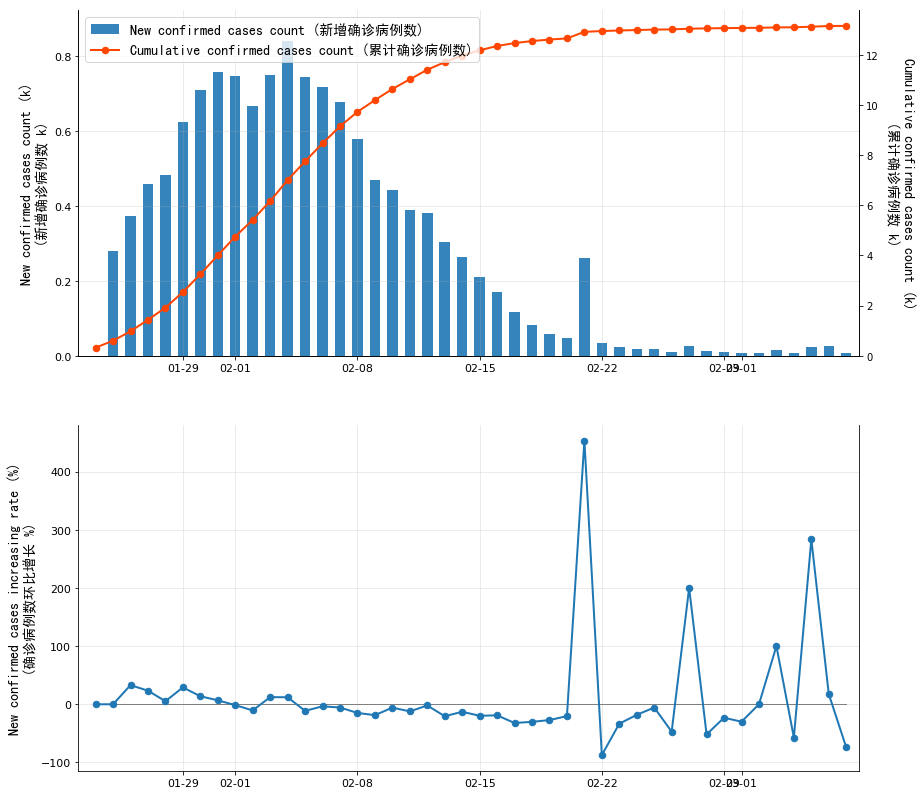

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

# above
bar_new_cfirmed = ax[0].bar(not_hubei_daily_df.index,
                            not_hubei_daily_df['province_confirmedCount_new'],
                            alpha=0.9,
                            width=0.6)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('New confirmed cases count (k)\n(新增确诊病例数 k)', size=12, fontproperties=fontP)
ax[0].set_ylim(bottom=0, top=not_hubei_daily_df['province_confirmedCount_new'].max()*1.1)
ax[0].yaxis.set_major_formatter(formatter_thousands_1dec)
ax[0].grid(which='major', alpha=0.3)
ax[0].spines['top'].set_visible(False)

ax_02 = ax[0].twinx()
line_cfirmed, = ax_02.plot(not_hubei_daily_df.index,
                           not_hubei_daily_df['province_confirmedCount'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.set_ylabel('Cumulative confirmed cases count (k)\n(累计确诊病例数 k)', rotation=270,
                 labelpad=35, size=12, fontproperties=fontP)
ax_02.set_ylim(bottom=0)
ax_02.xaxis.set_major_formatter(DATESFMT)
ax_02.yaxis.set_major_formatter(formatter_thousands)

ax_02.legend(handles=(bar_new_cfirmed, line_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('New confirmed cases count (新增确诊病例数)',
                     'Cumulative confirmed cases count (累计确诊病例数)'),
             loc=2)
ax_02.spines['top'].set_visible(False)

# below
ax[1].plot(not_hubei_daily_df.index,
           [0] * len(not_hubei_daily_df),
           color='gray', linewidth=1)
line_delta, = ax[1].plot(not_hubei_daily_df.index,
                         not_hubei_daily_df['province_confirmedCount_deltaRate'],
                         linewidth=2,
                         marker='.',
                         markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.3)
ax[1].spines['top'].set_visible(False)


# plt.show()
# plt.savefig('20200302_province_not_hubei.png', bbox_inches='tight')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，除湖北省以外的省份，每日新增确诊病例已从2月5日起连续下降，且从2月14日起，每日新增确诊已低于1月24日水平了，这一天是武汉封城的第二天。

2020年2月21日，三省五个监狱发现疫情，导致新增确诊病例大增：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。

--- English version ---

As of 24:00 Beijing time on {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}}, the number of newly confirmed cases per day in provinces other than Hubei Province has been declining continuously since February 5, and since February 14, the daily number of newly confirmed cases has been lower than the January 24th, which is the second day of Wuhan's closure.

On February 21, 2020, outbreaks were found in five prisons in three provinces: 230 cases were confirmed in Wuhan Women's Prison (Wuhan), 1 case was suspected by Hubei Province Juvenile Delinquent (Wuhan), and 41 cases were confirmed in Shayang Hanjin Prison (Jingmen). Nine cases were suspected, 200 cases were confirmed by Rencheng Prison (Jining), 10 cases were suspected, and 34 cases were confirmed by Shilifeng Prison (Luzhou). 

**Daily cumulative confirmed count for each province**

In [48]:
province_daily_df['province_confirmedCount'] = province_daily_df['province_confirmedCount'].astype(int)
province_daily_df['province_curedCount'] = province_daily_df['province_curedCount'].astype(int)
province_daily_df['province_deadCount'] = province_daily_df['province_deadCount'].astype(int)

In [49]:
province_daily_cfirmed_pvt = pd.pivot_table(data = province_daily_df,
                                            columns='Date_ymd',
                                            index='provinceName',
                                            values='province_confirmedCount')
province_daily_cfirmed_pvt = province_daily_cfirmed_pvt.sort_values(by=province_daily_cfirmed_pvt.columns[-1],
                                                                    ascending=False)


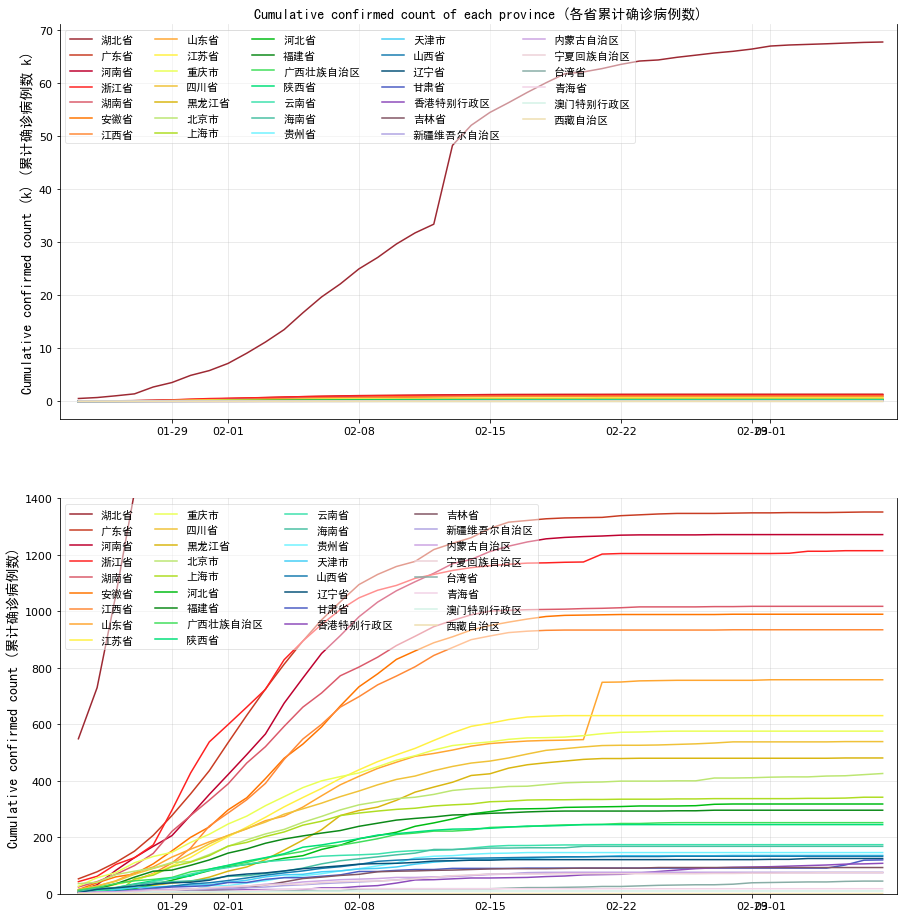

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Cumulative confirmed count of each provinces
ax[0].set_title('Cumulative confirmed count of each province (各省累计确诊病例数)',
                fontdict={'fontsize': 14}, fontproperties=fontP)

ax[0].set_prop_cycle(color=province_colors)
for city, d in province_daily_cfirmed_pvt.iterrows():
    ax[0].plot(d.index, d, label=city)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('Cumulative confirmed count (k) (累计确诊病例数 k)', fontproperties=fontP)
ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].spines['top'].set_visible(False)
ax[0].grid(which='major', alpha=0.3)
ax[0].legend(loc=2, ncol=5, prop=fontP_small, framealpha=0.5)
ax[0].yaxis.set_major_formatter(formatter_thousands)

ax[1].set_prop_cycle(color=province_colors)
for city, d in province_daily_cfirmed_pvt.iterrows():
    ax[1].plot(d.index, d, label=city)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('Cumulative confirmed count (累计确诊病例数)', fontproperties=fontP)
ax[1].set_ylim(bottom=0, top=1400)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].spines['top'].set_visible(False)
ax[1].grid(which='major', alpha=0.3)
ax[1].legend(loc=2, ncol=4, prop=fontP_small, framealpha=0.5)

# plt.show()
# plt.savefig('20200302_province_timeseries.png', bbox_inches='tight')

由上图可以看出，湖北省新增确诊病例数从2020年2月4日逐渐放缓，2月13日湖北省诊断标准更改，新增确诊数大大增加，随后新增确诊数量恢复至13日之前的速度。可以体现出与湖北省自身情况相比，已经有好转的迹象，但由于湖北省是新冠肺炎始发省份，最初的确诊病例就多于其他省份，且人们对此病毒的抵抗力偏低，所以导致湖北省的确诊病例远远高于其他省份（直辖市、自治区）。

此外，由下面的图不难看出，我们可以把除湖北省外的省份（直辖市、自治区）分成三组：一、累计确诊高于1100例的三个省份（广东省、河南省和浙江省），二、累计确诊介于900与1100例的三个省份（湖南省、安徽省和江西省），三、其他所有省份（直辖市、自治区）。第一组中起初累计确诊病例最多的省份为广东省，但于1月29日被浙江省反超，后来于2月5日超过浙江省，而浙江省的累计确诊病例数自2月8日起趋于平缓且于2月12日被河南省超过。广东省累计确诊病例多的原因可能跟广东省人口多有关，人口多，基数大，是导致累计确诊数量大的其中一个原因。河南省南临湖北省，地理位置相邻也许是该省累计确诊数量多的其中一个原因；另外，据央视新闻客户端报道，2020年1月23日，河南省许昌市刘某某在疫情期间为其儿子在许昌东城区某大酒店举办婚宴。2月5日，刘某某女儿确诊为新型冠状病毒肺炎病例后，面对疾控部门工作人员的询问，刘某刻意隐瞒其从武汉返乡的事实，也绝口不提家中曾办过婚礼大宴宾客。之后工作人员通过调查，发现婚宴的参与者共有约200人。此类“家庭聚集”事件也是促使新冠病毒传染的一大因素。

2020年2月21日，三省五个监狱发现疫情，导致新增确诊病例大增：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。

--- English version ---

According to the above figure, the number of newly confirmed cases in Hubei Province has gradually slowed down from February 4, 2020, and the diagnostic standards in Hubei Province have changed on February 13, the number of newly confirmed cases has increased significantly, the number of new confirmed subsequently recovered to the speed before the February 13. It can be shown that compared with the situation in Hubei Province, there are already signs of improvement, but since Hubei Province is the originating province of COVID-19, the initial confirmed cases are more than other provinces, and people's resistance to this virus is low, so as a result, the number of confirmed cases in Hubei Province is much higher than in other provinces (municipalities and autonomous regions).

In addition, it is not difficult to see from the second figure that we can divide the provinces (municipalities, autonomous regions) other than Hubei Province into three groups: 1. Three provinces (Guangdong, Henan, and Zhejiang) with a cumulative confirmed cases of more than 1100 cases Second, the three provinces (Hunan, Anhui and Jiangxi provinces) with a cumulative confirmed cases between 900 and 1100 cases, and all other provinces (municipalities, autonomous regions). In the first group, the province with the most cumulative confirmed cases was Guangdong Province, but was overtaken by Zhejiang Province on January 29, and later passed Zhejiang Province on February 5, and the cumulative number of confirmed cases in Zhejiang Province began on February 8. It flattened and was overtaken by Henan Province on February 12. The reason why the cumulative number of confirmed cases in Guangdong Province may be related to the large population in Guangdong Province. The large population is one of the reasons for the large number of cumulative diagnoses. The proximity of Henan Province to Hubei Province in the south may be one of the reasons why it has accumulated a large number of diagnoses. In addition, according to a CCTV news, on January 23, 2020, Liu hosted a wedding for his son in a restaurant during the epidemic. On February 5th, after Liu's daughter was diagnosed with a COVID-19, Liu concealed the fact that she returned from Wuhan. After investigation, the staff found that there were about 200 participants in the wedding reception. Such "family gathering" events are also a major factor in the transmission of the COVID-19.

On February 21, 2020, outbreaks were found in five prisons in three provinces: 230 cases were confirmed in Wuhan Women's Prison (Wuhan), 1 case was suspected by Hubei Province Juvenile Delinquent (Wuhan), and 41 cases were confirmed in Shayang Hanjin Prison (Jingmen). Nine cases were suspected, 200 cases were confirmed by Rencheng Prison (Jining), 10 cases were suspected, and 34 cases were confirmed by Shilifeng Prison (Luzhou). 

**Cumulative confirmed count daily evolution**

In [51]:
province_daily_cfirmed_evol = province_daily_cfirmed_pvt.pct_change(axis='columns')
province_daily_cfirmed_evol = province_daily_cfirmed_evol.fillna(0)

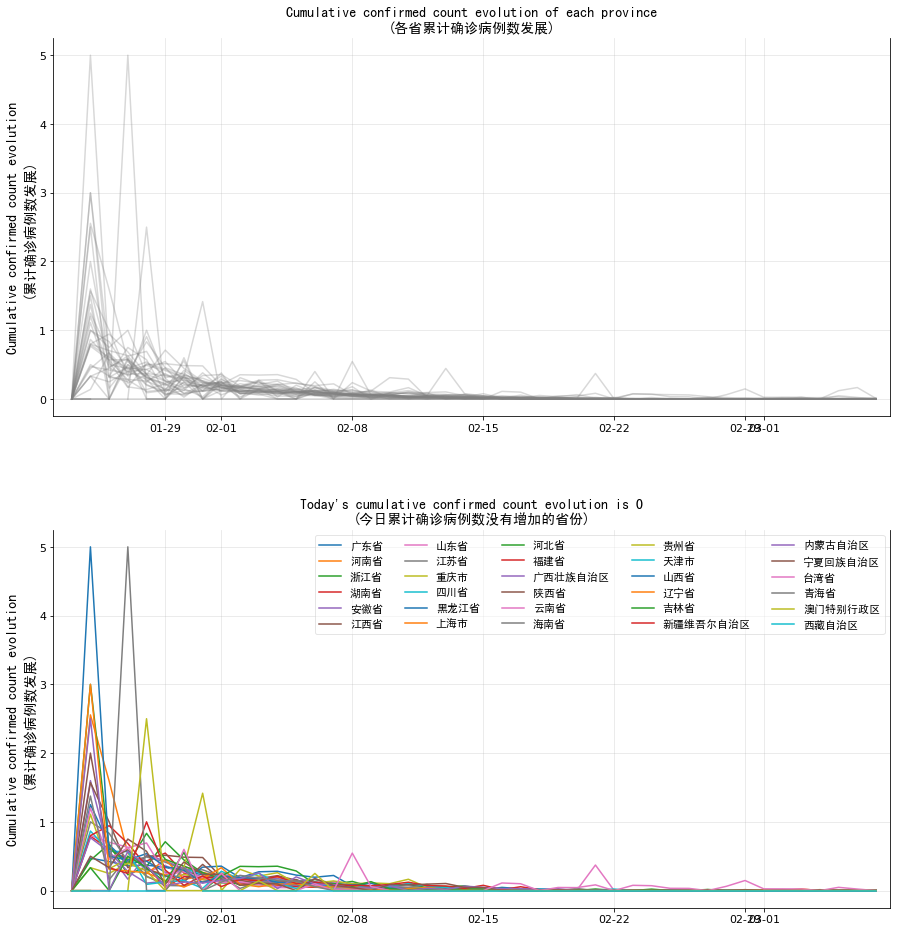

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Cumulative confirmed count evolution of each province
ax[0].set_title('Cumulative confirmed count evolution of each province\n(各省累计确诊病例数发展)',
                fontdict={'fontsize': 14}, fontproperties=fontP)

for city, d in province_daily_cfirmed_evol.iterrows():
    ax[0].plot(d.index, d, label=city, alpha=0.3, color='gray')

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('Cumulative confirmed count evolution\n(累计确诊病例数发展)', fontproperties=fontP)
ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].spines['top'].set_visible(False)
ax[0].grid(which='major', alpha=0.3)


ax[1].set_title('Today\'s cumulative confirmed count evolution is 0\n(今日累计确诊病例数没有增加的省份)',
             fontdict={'fontsize': 14}, fontproperties=fontP)

last_date = province_daily_cfirmed_evol.columns[-1]
for city, d in province_daily_cfirmed_evol[province_daily_cfirmed_evol[last_date]==0].iterrows():
    ax[1].plot(d.index, d, label=city)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('Cumulative confirmed count evolution\n(累计确诊病例数发展)', fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)

ax[1].spines['top'].set_visible(False)
ax[1].grid(which='major', alpha=0.3)
ax[1].legend(loc=1, ncol=5, prop=fontP_small, framealpha=0.5)

plt.subplots_adjust(hspace=0.3)
plt.show()

新型冠状肺炎爆发初期，各省（直辖市、自治区）每日新增确诊病例数量多且不稳定，自2月1日起，每日新增确诊病例百分比逐渐趋于平稳。

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，{{len(province_daily_cfirmed_evol[province_daily_cfirmed_evol[last_date]==0])}}个省（直辖市、自治区）较前一日无新增确诊病例，其中西藏自治区自1月29日起无新增确诊病例，青海省和澳门特别行政区自2月7日起无新增确诊病例，台湾省在2月10日于2月15日之间无新增确诊病例。

--- English version ---

In the early days of the outbreak of coronavirus, the number of newly confirmed cases in each province (municipality, municipality, and autonomous region) is large and unstable. Since February 1, the percentage of newly confirmed cases has gradually stabilized.

As of 24:00 Beijing time on {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}}, {{len(province_daily_cfirmed_evol[province_daily_cfirmed_evol[last_date]==0])}} provinces (municipalities and autonomous regions) have no new confirmed cases compared with the previous day, Tibet Autonomous Region has no new confirmed cases since January 29. There were no new confirmed cases in Qinghai Province and Hongkong since February 7. There were no new confirmed cases in Taiwan between February 10 and February 15.

## Per city

In [53]:
# Daily confirmed count per province (complet missing dates)
city_daily_cfirmed_pvt = pd.pivot_table(data=city_daily_last,
                                        index='Date_ymd',
                                        columns='pcName',
                                        values='city_confirmedCount',
                                        fill_value=0)
city_daily_cfirmed_pvt = city_daily_cfirmed_pvt.reset_index()

for i, v in city_daily_cfirmed_pvt.iterrows():
    for col in city_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            city_daily_cfirmed_pvt.loc[i, col] = city_daily_cfirmed_pvt.loc[i-1, col]

city_daily_cfirmed_pvt.index = city_daily_cfirmed_pvt.Date_ymd

city_daily_cfirmed_df = city_daily_cfirmed_pvt.stack()
city_daily_cfirmed_df = city_daily_cfirmed_df.to_frame().reset_index()
city_daily_cfirmed_df = city_daily_cfirmed_df[
    city_daily_cfirmed_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_cfirmed_df.columns = ['Date_ymd', 'pcName', 'city_confirmedCount']

In [54]:
# Daily dead count per province (complet missing dates)
city_daily_cured_pvt = pd.pivot_table(data=city_daily_last,
                                      index='Date_ymd',
                                      columns='pcName',
                                      values='city_curedCount',
                                      fill_value=0)
city_daily_cured_pvt = city_daily_cured_pvt.reset_index()

for i, v in city_daily_cured_pvt.iterrows():
    for col in city_daily_cured_pvt.columns[1:]:
        if i > 0:
            if v[col] == 0:
                city_daily_cured_pvt.loc[i, col] = city_daily_cured_pvt.loc[i-1, col]

city_daily_cured_pvt.index = city_daily_cured_pvt.Date_ymd

city_daily_cured_df = city_daily_cured_pvt.stack()
city_daily_cured_df = city_daily_cured_df.to_frame().reset_index()
city_daily_cured_df = city_daily_cured_df[
    city_daily_cured_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_cured_df.columns = ['Date_ymd', 'pcName', 'city_curedCount']

In [55]:
# Daily dead count per province (complet missing dates)
city_daily_dead_pvt = pd.pivot_table(data=city_daily_last,
                                      index='Date_ymd',
                                      columns='pcName',
                                      values='city_deadCount',
                                      fill_value=0)
city_daily_dead_pvt = city_daily_dead_pvt.reset_index()

for i, v in city_daily_dead_pvt.iterrows():
    for col in city_daily_dead_pvt.columns[1:]:
        if i > 0:
            if v[col] == 0:
                city_daily_dead_pvt.loc[i, col] = city_daily_dead_pvt.loc[i-1, col]

city_daily_dead_pvt.index = city_daily_dead_pvt.Date_ymd

city_daily_dead_df = city_daily_dead_pvt.stack()
city_daily_dead_df = city_daily_dead_df.to_frame().reset_index()
city_daily_dead_df = city_daily_dead_df[
    city_daily_dead_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_dead_df.columns = ['Date_ymd', 'pcName', 'city_deadCount']

In [56]:
city_daily_df = pd.merge(city_daily_cfirmed_df,
                         city_daily_cured_df,
                         on=['Date_ymd', 'pcName'],
                         how='left')
city_daily_df = pd.merge(city_daily_df,
                         city_daily_dead_df,
                         on=['Date_ymd', 'pcName'],
                         how='left')

### Actual confirmed count

In [57]:
city_last_df = city_daily_df[city_daily_df['Date_ymd'] == city_daily_df['Date_ymd'].max()]
city_last_df = city_last_df.reset_index(drop=True)

city_last_df['city_act_confirmedCount'] = \
city_last_df['city_confirmedCount'] - city_last_df['city_curedCount'] - city_last_df['city_deadCount']
city_last_df = city_last_df[(city_last_df['city_confirmedCount'] > 0) &
                            (city_last_df['city_act_confirmedCount'] >= 0)]

city_last_df['cured_pct'] = \
city_last_df['city_curedCount'] / city_last_df['city_confirmedCount'] * 100
city_last_df['mortality_pct'] = \
city_last_df['city_deadCount'] / city_last_df['city_confirmedCount'] * 100

In [58]:
print('Actual confirmed count Top 10 cities（现有确诊病例数量排名前十的城市）：\n')
city_last_df.sort_values('city_act_confirmedCount', ascending=False).head(10)

Actual confirmed count Top 10 cities（现有确诊病例数量排名前十的城市）：



Date_ymd     pcName city_confirmedCount city_curedCount city_deadCount  \
335  2020-03-07     湖北省-武汉               49871           28536           2349   
330  2020-03-07     湖北省-孝感                3518            2972            123   
342  2020-03-07     湖北省-鄂州                1394             956             54   
332  2020-03-07  湖北省-待明确地区                 312              12              0   
337  2020-03-07   湖北省-监狱系统                 253               3              0   
343  2020-03-07     湖北省-随州                1307            1048             43   
148  2020-03-07   山东省-任城监狱                 200               0              0   
344  2020-03-07     湖北省-黄冈                2907            2582            125   
331  2020-03-07     湖北省-宜昌                 931             707             33   
339  2020-03-07     湖北省-荆州                1580            1351             48   

    city_act_confirmedCount cured_pct mortality_pct  
335                   18986   57.2196       4.71015  
330                     423   84.4798        3.4963  
342                     384   68.5796       3.87374  
332                     300   3.84615             0  
337                     250   1.18577             0  
343                     216   80.1836       3.28998  
148                     200         0             0  
344                     200   88.8201       4.29997  
331                     191   75.9398       3.54458  
339                     181   85.5063       3.03797

In [59]:
print('Cities recover 0 actual confirmed case（现存确诊病例为零的城市）：\n')
city_last_df[city_last_df['city_act_confirmedCount'] == 0]

Cities recover 0 actual confirmed case（现存确诊病例为零的城市）：



Date_ymd       pcName city_confirmedCount city_curedCount  \
3    2020-03-07      上海市-奉贤区                   9               9   
5    2020-03-07      上海市-崇明区                   4               4   
8    2020-03-07      上海市-普陀区                  11              11   
10   2020-03-07      上海市-杨浦区                   9               9   
14   2020-03-07      上海市-金山区                   4               4   
15   2020-03-07      上海市-长宁区                  13              13   
16   2020-03-07      上海市-闵行区                  19              19   
20   2020-03-07       云南省-临沧                   1               1   
21   2020-03-07       云南省-丽江                   7               7   
22   2020-03-07       云南省-保山                   9               9   
24   2020-03-07      云南省-大理州                  13              13   
29   2020-03-07      云南省-文山州                   2               2   
30   2020-03-07       云南省-昆明                  53              53   
31   2020-03-07       云南省-昭通                  25              25   
32   2020-03-07       云南省-普洱                   4               4   
36   2020-03-07      云南省-楚雄州                   4               4   
37   2020-03-07       云南省-玉溪                  14              13   
39   2020-03-07      云南省-红河州                   9               9   
40   2020-03-07     云南省-西双版纳                  15              14   
42   2020-03-07   内蒙古自治区-乌海市                   2               2   
43   2020-03-07   内蒙古自治区-兴安盟                   1               1   
45   2020-03-07  内蒙古自治区-呼伦贝尔                   7               7   
47   2020-03-07  内蒙古自治区-巴彦淖尔                   8               7   
49   2020-03-07    内蒙古自治区-通辽                   7               7   
50   2020-03-07  内蒙古自治区-鄂尔多斯                  11              11   
73   2020-03-07      吉林省-公主岭                   6               6   
74   2020-03-07      吉林省-吉林市                   5               5   
75   2020-03-07       吉林省-四平                  15              14   
76   2020-03-07       吉林省-延边                   5               5   
77   2020-03-07       吉林省-松原                   2               2   
..          ...          ...                 ...             ...   
408  2020-03-07       辽宁省-锦州                  12              12   
409  2020-03-07       辽宁省-阜新                   8               8   
412  2020-03-07    重庆市-万盛经开区                   1               1   
418  2020-03-07      重庆市-合川区                  23              23   
420  2020-03-07      重庆市-城口县                   2               2   
421  2020-03-07     重庆市-大渡口区                   7               7   
424  2020-03-07      重庆市-巫山县                  10              10   
425  2020-03-07      重庆市-巫溪县                  14              14   
427  2020-03-07      重庆市-开州区                  21              20   
428  2020-03-07      重庆市-彭水县                   2               2   
430  2020-03-07       重庆市-忠县                  21              21   
431  2020-03-07      重庆市-梁平区                   4               4   
432  2020-03-07      重庆市-武隆区                   1               1   
433  2020-03-07      重庆市-永川区                   5               5   
435  2020-03-07      重庆市-江津区                   4               4   
441  2020-03-07      重庆市-璧山区                   9               9   
443  2020-03-07      重庆市-秀山县                   1               1   
446  2020-03-07       重庆市-酉阳                   1               1   
449  2020-03-07      重庆市-高新区                   4               4   
450  2020-03-07      重庆市-黔江区                   2               2   
454  2020-03-07       陕西省-宝鸡                  13              13   
455  2020-03-07       陕西省-延安                   8               8   
457  2020-03-07       陕西省-杨凌                   1               1   
458  2020-03-07       陕西省-榆林                   3               3   
463  2020-03-07       陕西省-韩城                   1               1   
465  2020-03-07      青海省-海北州                   3               3   
466  2020-03-07       青海省-西宁                  15              1

In [60]:
print('Cured rate Top 10 cities（治愈率排名前十的城市）：\n')
city_last_df.sort_values('cured_pct', ascending=False).head(10)

Cured rate Top 10 cities（治愈率排名前十的城市）：



Date_ymd      pcName city_confirmedCount city_curedCount  \
243  2020-03-07      江苏省-泰州                  37              37   
194  2020-03-07      广东省-湛江                  22              22   
198  2020-03-07      广东省-茂名                  14              14   
199  2020-03-07      广东省-阳江                  14              14   
418  2020-03-07     重庆市-合川区                  23              23   
208  2020-03-07  广西壮族自治区-梧州                   5               5   
210  2020-03-07  广西壮族自治区-玉林                  11              11   
211  2020-03-07  广西壮族自治区-百色                   3               3   
212  2020-03-07  广西壮族自治区-贵港                   8               8   
213  2020-03-07  广西壮族自治区-贺州                   4               4   

    city_deadCount city_act_confirmedCount cured_pct mortality_pct  
243              0                       0       100             0  
194              0                       0       100             0  
198              0                       0       100             0  
199              0                       0       100             0  
418              0                       0       100             0  
208              0                       0       100             0  
210              0                       0       100             0  
211              0                       0       100             0  
212              0                       0       100             0  
213              0                       0       100             0

In [61]:
print('Mortality Top 10 cities（死亡率排名前十的城市）：\n')
city_last_df.sort_values('mortality_pct', ascending=False).head(10)

Mortality Top 10 cities（死亡率排名前十的城市）：



Date_ymd              pcName city_confirmedCount city_curedCount  \
310  2020-03-07              海南省-东方                   3               2   
315  2020-03-07              海南省-定安                   3               2   
222  2020-03-07  新疆维吾尔自治区-兵团第八师石河子市                   4               3   
220  2020-03-07      新疆维吾尔自治区-兵团第九师                   4               2   
324  2020-03-07              海南省-琼海                   6               5   
273  2020-03-07             河南省-三门峡                   7               6   
316  2020-03-07           海南省-待明确地区                   7               3   
47   2020-03-07         内蒙古自治区-巴彦淖尔                   8               7   
322  2020-03-07              海南省-澄迈                   9               8   
269  2020-03-07             河北省-秦皇岛                  10               9   

    city_deadCount city_act_confirmedCount cured_pct mortality_pct  
310              1                       0   66.6667       33.3333  
315              1                       0   66.6667       33.3333  
222              1                       0        75            25  
220              1                       1        50            25  
324              1                       0   83.3333       16.6667  
273              1                       0   85.7143       14.2857  
316              1                       3   42.8571       14.2857  
47               1                       0      87.5          12.5  
322              1                       0   88.8889       11.1111  
269              1                       0        90            10

### 六大地理分区

- 华北地区（北京市、天津市、河北省、山西省）<br>
- 东北地区（辽宁省、吉林省、黑龙江省、内蒙古自治区）<br>
- 华东地区（上海市、江苏省、浙江省、安徽省、福建省、江西省、山东省、台湾省）<br>
- 中南地区（河南省、湖北省、湖南省、广东省、广西壮族自治区、海南省、香港特别行政区、澳门特别行政区）<br>
- 西南地区（四川省、贵州省、云南省、重庆市、西藏自治区）<br>
- 西北地区（陕西省、甘肃省、青海省、宁夏回族自治区、新疆维吾尔自治区）<br>

In [62]:
province_region_dict = {'北京市':'华北地区',
                        '河北省':'华北地区',
                        '天津市':'华北地区',
                        '山西省':'华北地区',
                        '辽宁省':'东北地区',
                        '吉林省':'东北地区',
                        '黑龙江省':'东北地区',
                        '内蒙古自治区':'东北地区',
                        '上海市':'华东地区',
                        '安徽省':'华东地区',
                        '山东省':'华东地区',
                        '江苏省':'华东地区',
                        '江西省':'华东地区',
                        '浙江省':'华东地区',
                        '福建省':'华东地区',
                        '台湾省':'华东地区',
                        '广东省':'中南地区',
                        '河南省':'中南地区',
                        '海南省':'中南地区',
                        '湖北省':'中南地区',
                        '湖南省':'中南地区',
                        '广西壮族自治区':'中南地区',
                        '香港特别行政区':'中南地区',
                        '澳门特别行政区':'中南地区',
                        '四川省':'西南地区',
                        '云南省':'西南地区',
                        '贵州省':'西南地区',
                        '重庆市':'西南地区',
                        '西藏自治区':'西南地区',
                        '甘肃省':'西北地区',
                        '陕西省':'西北地区',
                        '青海省':'西北地区',
                        '宁夏回族自治区':'西北地区',
                        '新疆维吾尔自治区':'西北地区'}

In [63]:
provinceCity_last_df = pd.merge(city_last_df,
                                city_daily_last[['pcName', 'provinceName']].drop_duplicates(),
                                on='pcName')

provinceCity_last_df['region'] = provinceCity_last_df['provinceName'].map(province_region_dict)

In [64]:
provinceCity_daily_last_df = pd.merge(city_daily_df,
                                      city_daily_last[['pcName', 'provinceName']].drop_duplicates(),
                                      on='pcName')

provinceCity_daily_last_df['city_act_confirmedCount'] = \
provinceCity_daily_last_df['city_confirmedCount'] - \
provinceCity_daily_last_df['city_curedCount'] - \
provinceCity_daily_last_df['city_deadCount']

provinceCity_daily_last_df = provinceCity_daily_last_df[(provinceCity_daily_last_df['city_confirmedCount'] > 0) &
                            (provinceCity_daily_last_df['city_act_confirmedCount'] >= 0)]

provinceCity_daily_last_df['cured_pct'] = \
provinceCity_daily_last_df['city_curedCount'] / provinceCity_daily_last_df['city_confirmedCount'] * 100
provinceCity_daily_last_df['mortality_pct'] = \
provinceCity_daily_last_df['city_deadCount'] / provinceCity_daily_last_df['city_confirmedCount'] * 100

provinceCity_daily_last_df['region'] = provinceCity_daily_last_df['provinceName'].map(province_region_dict)
provinceCity_daily_last_df['city_confirmedCount'] = provinceCity_daily_last_df['city_confirmedCount'].astype(int)

In [65]:
def region_scatter_line_charts(provinceCity_last_df, provinceCity_daily_last_df, title,
                               region, loc, ncol, bbox_to_anchor, color=province_colors, scale=3):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

    last_df = provinceCity_last_df[provinceCity_last_df['region'] == region].sort_values(
        'city_confirmedCount', ascending=False)

    label_cities = []
    ax[0].set_title(title, fontdict={'fontsize': 14}, fontproperties=fontP)
    ax[0].set_prop_cycle(color=color)
    for i, rows in last_df.iterrows():
        if rows['mortality_pct'] > 0 or \
        rows['city_confirmedCount'] > last_df['city_confirmedCount'].mean():
            ax[0].scatter(x=rows['city_confirmedCount'],
                          y=rows['mortality_pct'],
                          s=(rows['city_confirmedCount'])*scale,
                          label=rows['pcName'])
            label_cities.append(rows['pcName'])
        else:
            ax[0].scatter(x=rows['city_confirmedCount'],
                          y=rows['mortality_pct'],
                          s=(rows['city_confirmedCount'])*scale)

    ax[0].tick_params(labelsize=12)
    ax[0].set_xlabel('Cumulative confirmed count (累计确诊病例)', fontproperties=fontP)
    ax[0].set_ylabel('Mortality % (死亡率 %)', fontproperties=fontP)
    ax[0].legend(loc=loc, ncol=ncol, prop=fontP_small, framealpha=0.5, bbox_to_anchor=bbox_to_anchor)

    ax[0].axhline(last_df['mortality_pct'].mean(),
                  color='dimgray', linestyle='--')
    ax[0].axvline(last_df['city_confirmedCount'].mean(),
                  color='dimgray', linestyle='--')

    ax[0].text(x=last_df['city_confirmedCount'].max() * 0.8,
               y=last_df['mortality_pct'].mean() * 1.3,
               s='Average mortality = {:.1f}'.format(last_df['mortality_pct'].mean()),
               fontsize=12)
    ax[0].text(x=last_df['city_confirmedCount'].mean() * 0.4,
               y=last_df['mortality_pct'].max() * 0.9,
               s='Average cumulative confirmed count = {:.1f}'.format(last_df['city_confirmedCount'].mean()),
               fontsize=12)

    ax[1].set_prop_cycle(color=province_colors)
    provinceCity_daily_pvt = pd.pivot_table(data=provinceCity_daily_last_df[
        provinceCity_daily_last_df['region']==region],
                                            index='pcName',
                                            columns='Date_ymd',
                                            values='city_confirmedCount',
                                            fill_value=0)
    provinceCity_daily_pvt = provinceCity_daily_pvt.sort_values(by=provinceCity_daily_pvt.columns[-1],
                                                                ascending=False)

    for city, d in provinceCity_daily_pvt.iterrows():
        if city in label_cities:
            ax[1].plot(d.index, d, label=city)

    ax[1].tick_params(labelsize=11)
    ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
    ax[1].set_ylabel('Cumulative confirmed count (累计确诊病例数)', fontproperties=fontP)
    ax[1].xaxis.set_major_formatter(DATESFMT)
    ax[1].spines['top'].set_visible(False)
    ax[1].grid(which='major', alpha=0.3)
    ax[1].legend(loc=2, ncol=3, prop=fontP_small, framealpha=0.5)
    
    return last_df, provinceCity_daily_pvt


**华北地区（北京市、天津市、河北省、山西省）**

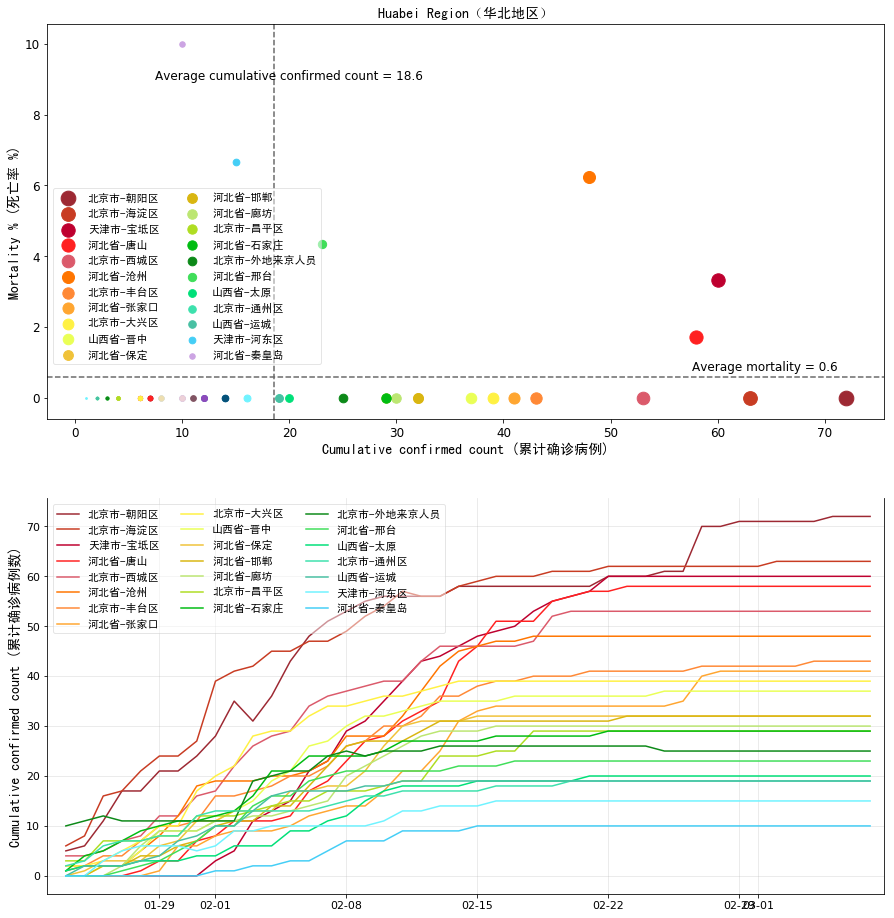

In [66]:
huabei_last_df, huabei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                              provinceCity_daily_last_df,
                                                              title='Huabei Region（华北地区）',
                                                              region='华北地区',
                                                              loc=2,
                                                              ncol=2,
                                                              bbox_to_anchor=(0, 0.6))
# plt.savefig('20200302_huabei.png', bbox_inches='tight')

In [67]:
# huabei_daily_pvt.to_csv('huabei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，华北地区累计确诊病例平均值为{{int(round(huabei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{huabei_last_df.loc[huabei_last_df['city_confirmedCount'] == huabei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{huabei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{huabei_last_df.loc[huabei_last_df['mortality_pct'] == huabei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(huabei_last_df.mortality_pct.max(), 2)}}%。

需要特别注意的是天津市宝坻区和河北省唐山市，他们分别于2020年2月1日和1月28日才出现第一例确诊病例，却出现快速增长的现象，于2月21日达到华北地区确诊病例并列第三的情况。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00, {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}} Beijing time, the average number of confirmed cases in North China was {{int(round(huabei_last_df.city_confirmedCount.mean(), 0))}}, and the city (district) with the largest number of confirmed cases was {{huabei_last_df.loc[huabei_last_df['city_confirmedCount'] == huabei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Beijing-Chaoyang District), with a total of {{huabei_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) where the cumulative confirmed cases were larger than the region's average and the mortality rate was positive, {{huabei_last_df.loc[huabei_last_df['mortality_pct'] == huabei_last_df.mortality_pct.max(), 'pcName'].values[0]}}(Hebei Province-Qinhuangdao) had the highest mortality rate of {{round(huabei_last_df.mortality_pct.max(), 2)}}%.

It is important to note that Baodi District of Tianjin City and Tangshan City of Hebei Province had their first confirmed cases only on February 1, 2020, and January 28, 2020, but they experienced rapid growth, reaching on February 21. The number of confirmed cases in North China is the third.

_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

**东北地区（辽宁省、吉林省、黑龙江省、内蒙古自治区）**

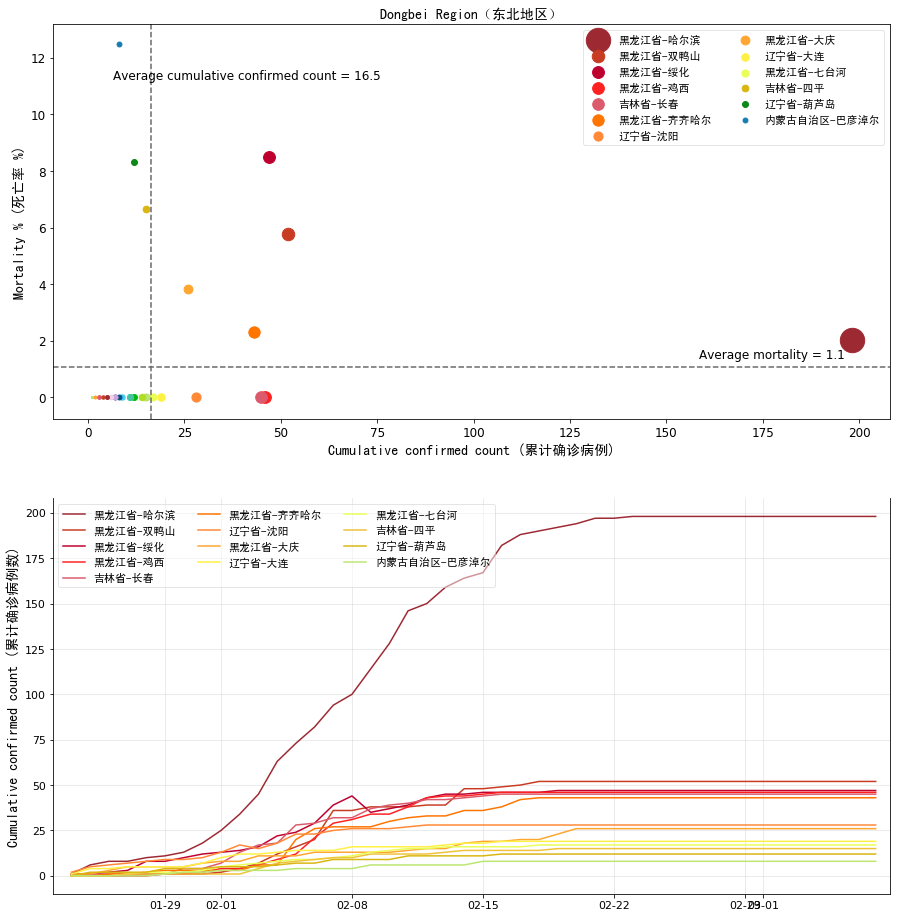

In [68]:
dongbei_last_df, dongbei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                provinceCity_daily_last_df,
                                                                title='Dongbei Region（东北地区）',
                                                                region='东北地区',
                                                                loc=1,
                                                                ncol=2,
                                                                bbox_to_anchor=(1, 1))

In [69]:
# dongbei_daily_pvt.to_csv('dongbei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，东北地区累计确诊病例平均值为{{int(round(dongbei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{dongbei_last_df.loc[dongbei_last_df['city_confirmedCount'] == dongbei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{dongbei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{dongbei_last_df.loc[dongbei_last_df['mortality_pct'] == dongbei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(dongbei_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00 Beijing time {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}} , the average number of cumulative confirmed cases in Northeast China was {{int(round(dongbei_last_df.city_confirmedCount.mean(), 0))}} and the city (district) with the largest number of cumulative confirmed cases was {{dongbei_last_df.loc[dongbei_last_df['city_confirmedCount'] == dongbei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Heilongjiang Province-Harbin) with a total of {{dongbei_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) where the cumulative number of confirmed cases was greater than the regional average and the mortality rate was positive, {{dongbei_last_df.loc[dongbei_last_df['mortality_pct'] == dongbei_last_df.mortality_pct.max(), 'pcName'].values[0]}}(Heilongjiang Province-Suihua) had the highest mortality rate of {{round(dongbei_last_df.mortality_pct.max(), 2)}}%.

_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

**华东地区（上海市、江苏省、浙江省、安徽省、福建省、江西省、山东省、台湾省）**

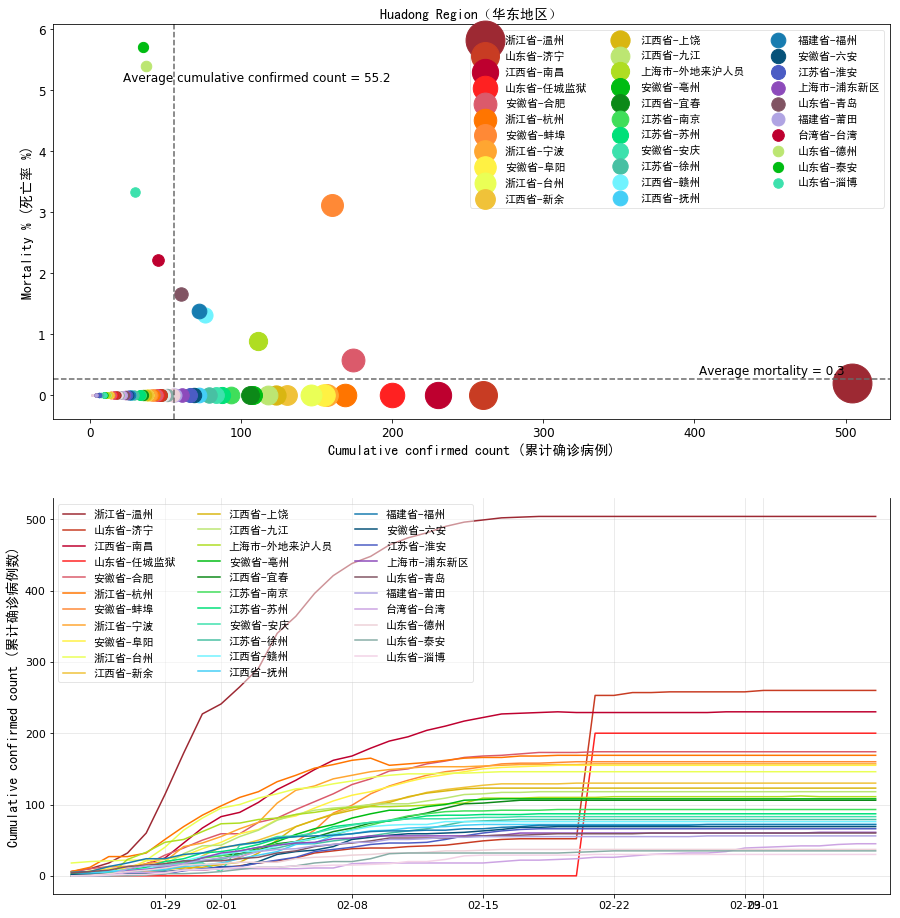

In [70]:
huadong_last_df, huadong_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                provinceCity_daily_last_df,
                                                                title='Huadong Region（华东地区）',
                                                                region='华东地区',
                                                                loc=1,
                                                                ncol=3,
                                                                bbox_to_anchor=(1, 1))


In [71]:
# huadong_daily_pvt.to_csv('huadong_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，华东地区累计确诊病例平均值为{{int(round(huadong_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{huadong_last_df.loc[huadong_last_df['city_confirmedCount'] == huadong_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{huadong_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{huadong_last_df.loc[huadong_last_df['mortality_pct'] == huadong_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(huadong_last_df.mortality_pct.max(), 2)}}%。

需要特别注意的是山东省济宁和任城监狱确诊病例于2020年2月21日的大幅度增长来自于任城监狱确诊了200例病例。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00, {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}} Beijing time, the average cumulative number of confirmed cases in East China was {{int(round(huadong_last_df.city_confirmedCount.mean(), 0))}}. The city (district) with the largest number of cumulative confirmed cases was {{huadong_last_df.loc[huadong_last_df['city_confirmedCount'] == huadong_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Zhejiang-Wenzhou), with a total of {{huadong_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) with cumulative diagnosed cases that were larger than the regional average and positive mortality rates, {{huadong_last_df.loc[huadong_last_df['mortality_pct'] == huadong_last_df.mortality_pct.max(), 'pcName'].values[0]}}(Shandong-Taian) had the highest mortality rate of {{round(huadong_last_df.mortality_pct.max(), 2)}}%.

It is important to note that the substantial increase in confirmed cases in Jining and Rencheng prisons in Shandong Province on February 21, 2020 came from the 200 confirmed cases in Rencheng prison.

_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

**中南地区（河南省、湖北省、湖南省、广东省、广西壮族自治区、海南省、香港特别行政区、澳门特别行政区）**

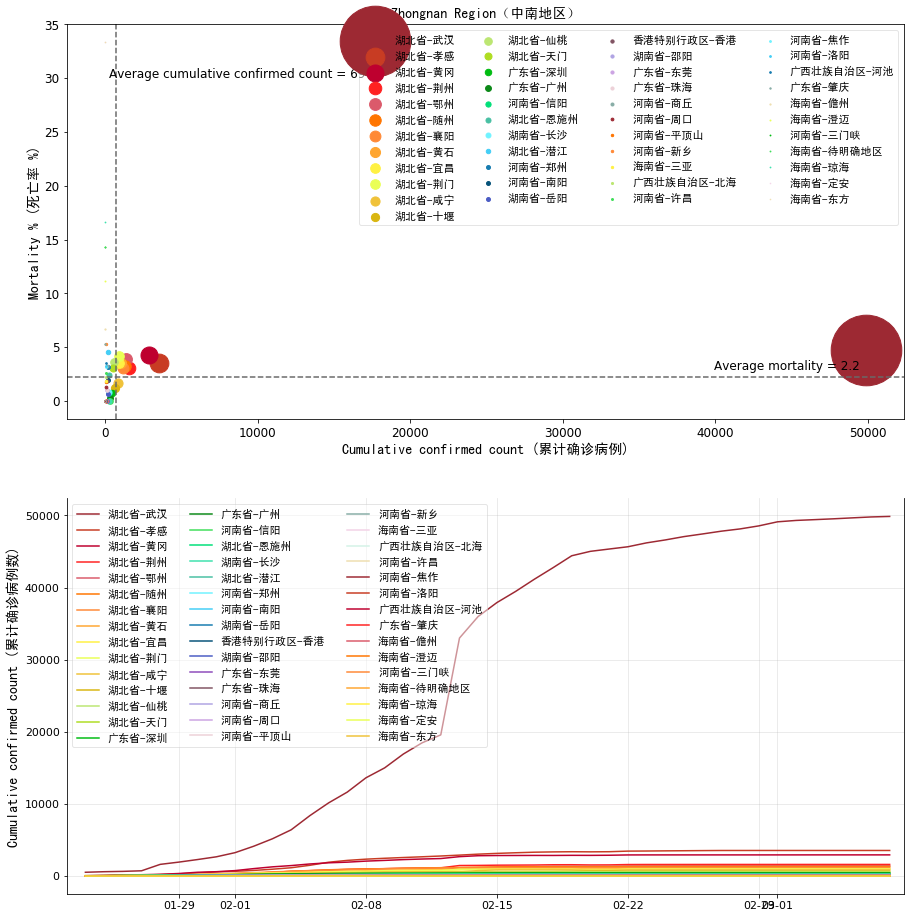

In [72]:
zhongnan_last_df, zhongnan_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                  provinceCity_daily_last_df,
                                                                  title='Zhongnan Region（中南地区）',
                                                                  region='中南地区',
                                                                  loc=1,
                                                                  ncol=4,
                                                                  bbox_to_anchor=(1, 1),
                                                                  scale=0.1)

In [73]:
# zhongnan_daily_pvt.to_csv('zhongnan_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，中南地区累计确诊病例平均值为{{int(round(zhongnan_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{zhongnan_last_df.loc[zhongnan_last_df['city_confirmedCount'] == zhongnan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{zhongnan_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{zhongnan_last_df.loc[zhongnan_last_df['mortality_pct'] == zhongnan_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(zhongnan_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00 Beijing time on {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}}, the average number of confirmed cases in Central and South China was {{int(round(zhongnan_last_df.city_confirmedCount.mean(), 0))}}, and the city (district) with the largest number of confirmed cases was {{zhongnan_last_df.loc[zhongnan_last_df['city_confirmedCount'] == zhongnan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Hubei Province-Wuhan), with a total of {{zhongnan_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) where the cumulative number of confirmed cases was greater than the regional average and the mortality rate was positive, {{zhongnan_last_df.loc[zhongnan_last_df['mortality_pct'] == zhongnan_last_df.mortality_pct.max(), 'pcName'].values[0]}}(Hainan Province-Ding'an) had the highest mortality rate of {{round(zhongnan_last_df.mortality_pct.max(), 2)}}%.


_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

**西南地区（四川省、贵州省、云南省、重庆市、西藏自治区）**

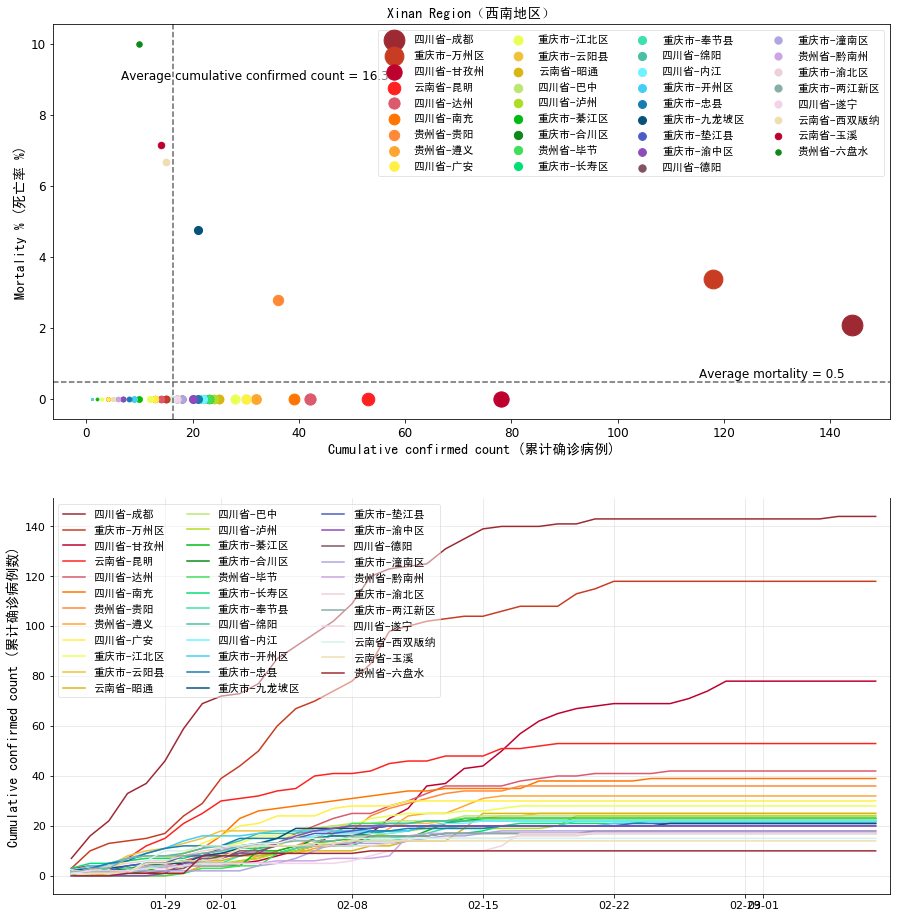

In [74]:
xinan_last_df, xinan_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                            provinceCity_daily_last_df,
                                                            title='Xinan Region（西南地区）',
                                                            region='西南地区',
                                                            loc=1,
                                                            ncol=4,
                                                            bbox_to_anchor=(1, 1))


In [75]:
# xinan_daily_pvt.to_csv('xinan_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，西南地区累计确诊病例平均值为{{int(round(xinan_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{xinan_last_df.loc[xinan_last_df['city_confirmedCount'] == xinan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{xinan_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{xinan_last_df.loc[xinan_last_df['mortality_pct'] == xinan_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(xinan_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00 Beijing time {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}}, the average number of confirmed cases in the southwestern region was {{int(round(xinan_last_df.city_confirmedCount.mean(), 0))}} and the city (district) with the largest number of confirmed cases was {{xinan_last_df.loc[xinan_last_df['city_confirmedCount'] == xinan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Sichuan Province-Chengdu), with a total of {{xinan_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) where the cumulative confirmed cases were larger than the average in the region and the mortality rate was positive, {{xinan_last_df.loc[xinan_last_df['mortality_pct'] == xinan_last_df.mortality_pct.max(), 'pcName'].values[0]}}(Guizhou Province-Liupanshui) had the highest mortality rate, at {{round(xinan_last_df.mortality_pct.max(), 2)}}%.

_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

**西北地区（陕西省、甘肃省、青海省、宁夏回族自治区、新疆维吾尔自治区）**

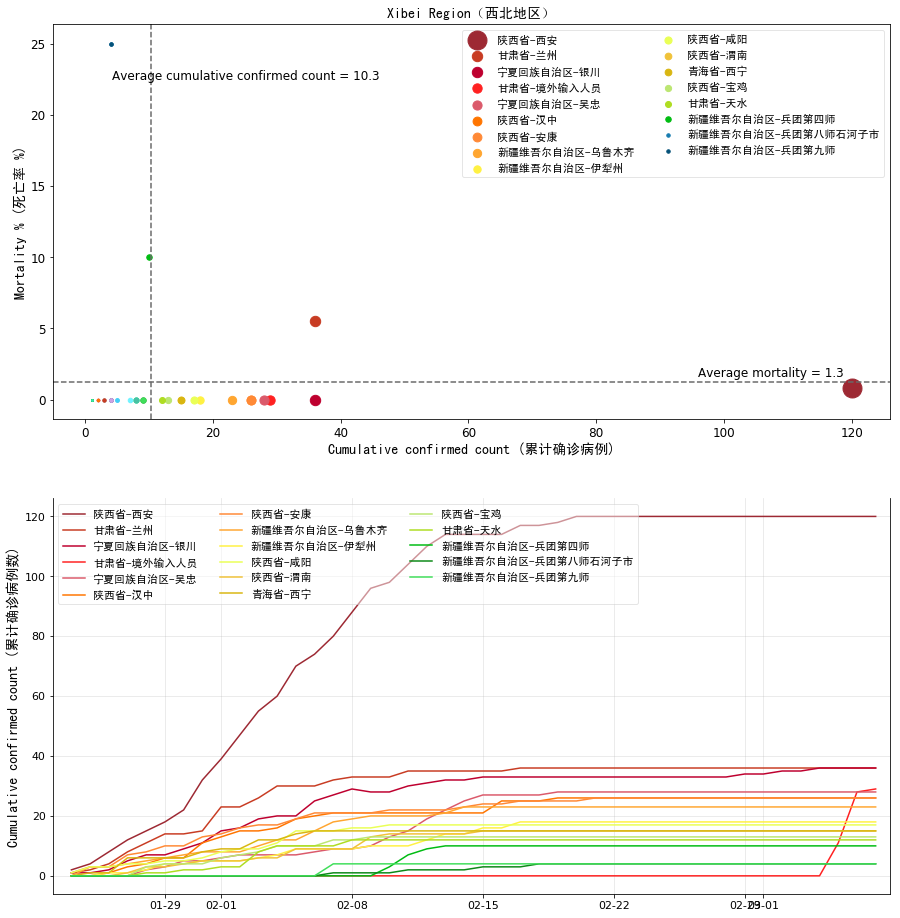

In [76]:
xibei_last_df, xibei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                            provinceCity_daily_last_df,
                                                            title='Xibei Region（西北地区）',
                                                            region='西北地区',
                                                            loc=1,
                                                            ncol=2,
                                                            bbox_to_anchor=(1, 1))

In [77]:
# xibei_daily_pvt.to_csv('xibei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，西北地区累计确诊病例平均值为{{int(round(xibei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{xibei_last_df.loc[xibei_last_df['city_confirmedCount'] == xibei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{xibei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{xibei_last_df.loc[xibei_last_df['mortality_pct'] == xibei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(xibei_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

--- English version ---

As of 24:00, {{not_hubei_daily_df.index[-1].day}}/{{not_hubei_daily_df.index[-1].month}}/{{not_hubei_daily_df.index[-1].year}} Beijing time, the average number of cumulative confirmed cases in the Northwest is {{int(round(xibei_last_df.city_confirmedCount.mean(), 0))}}, and the city (district) with the largest number of cumulative confirmed cases is {{xibei_last_df.loc[xibei_last_df['city_confirmedCount'] == xibei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}(Shaanxi Province-Xi'an), with a total of {{xibei_last_df.city_confirmedCount.max()}} cases. Among the cities (districts) where the cumulative number of confirmed cases was greater than the regional average and the mortality rate was positive, {{xibei_last_df.loc[xibei_last_df['mortality_pct'] == xibei_last_df.mortality_pct.max(), 'pcName'].values[0]}}(the Xinjiang Uygur Autonomous Region-Bingtuan Eighth Division Shihezi City) had the highest mortality rate, at {{round(xibei_last_df.mortality_pct.max(), 2)}}%.

_Note: The above figure only labels the cities (districts) whose cumulative confirmed cases are greater than the average of the region and whose mortality is positive._

## World

In [127]:
world_data_df = pd.read_csv('DXY_Country.csv')
world_data_df['updateTime'] = world_data_df.updateTime.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
world_data_df['Date_ymd'] = world_data_df['updateTime'].apply(lambda d: d.date())
world_data_df['Time_hms'] = world_data_df['updateTime'].apply(lambda d: d.time())

In [79]:
world_pop19_df = pd.read_csv('population_2019.csv')
world_pop19_df = world_pop19_df[['name', 'pop2019(k)']]
world_pop19_df.columns = ['countryName', 'population2019_k']

In [80]:
world_pop19_df.head()

countryName  population2019_k
0       China       1433783.686
1       India       1366417.754
2          US        329064.917
3   Indonesia        270625.568
4    Pakistan        216565.318

In [128]:
# Daily confirmed count per country (complet missing dates)
country_daily_cfirmed_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='confirmedCount',
    aggfunc='sum',
    fill_value=0)
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.reset_index()

for i, v in country_daily_cfirmed_pvt.iterrows():
    for col in country_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_cfirmed_pvt.loc[i, col] = country_daily_cfirmed_pvt.loc[i-1, col]

country_daily_cfirmed_pvt.index = country_daily_cfirmed_pvt.Date_ymd

country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.stack()
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.to_frame().reset_index()
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt[
    country_daily_cfirmed_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_cfirmed_pvt.columns = ['Date_ymd', 'countryName', 'country_confirmedCount']

In [129]:
# Daily cured count per country (complet missing dates)
country_daily_cured_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='curedCount',
    aggfunc='sum',
    fill_value=0)
country_daily_cured_pvt = country_daily_cured_pvt.reset_index()

for i, v in country_daily_cured_pvt.iterrows():
    for col in country_daily_cured_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_cured_pvt.loc[i, col] = country_daily_cured_pvt.loc[i-1, col]

country_daily_cured_pvt.index = country_daily_cured_pvt.Date_ymd

country_daily_cured_pvt = country_daily_cured_pvt.stack()
country_daily_cured_pvt = country_daily_cured_pvt.to_frame().reset_index()
country_daily_cured_pvt = country_daily_cured_pvt[
    country_daily_cured_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_cured_pvt.columns = ['Date_ymd', 'countryName', 'country_curedCount']

In [130]:
# Daily dead count per country (complet missing dates)
country_daily_dead_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='deadCount',
    aggfunc='sum',
    fill_value=0)
country_daily_dead_pvt = country_daily_dead_pvt.reset_index()

for i, v in country_daily_dead_pvt.iterrows():
    for col in country_daily_dead_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_dead_pvt.loc[i, col] = country_daily_dead_pvt.loc[i-1, col]

country_daily_dead_pvt.index = country_daily_dead_pvt.Date_ymd

country_daily_dead_pvt = country_daily_dead_pvt.stack()
country_daily_dead_pvt = country_daily_dead_pvt.to_frame().reset_index()
country_daily_dead_pvt = country_daily_dead_pvt[
    country_daily_dead_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_dead_pvt.columns = ['Date_ymd', 'countryName', 'country_deadCount']

In [131]:
country_daily_df = pd.merge(country_daily_cfirmed_pvt,
                            country_daily_cured_pvt,
                            on=['Date_ymd', 'countryName'])
country_daily_df = pd.merge(country_daily_df,
                            country_daily_dead_pvt,
                            on=['Date_ymd', 'countryName'])

In [132]:
country_daily_df.index = country_daily_df['Date_ymd']

country_daily_df['mortality_pct'] = country_daily_df.apply(lambda row:calcul_percentage(
    row['country_deadCount'], row['country_confirmedCount']), axis='columns')

country_daily_df['cured_pct'] = country_daily_df.apply(lambda row:calcul_percentage(
    row['country_curedCount'], row['country_confirmedCount']), axis='columns')

# country_daily_df['country_confirmedCount_new'] = country_daily_df['country_confirmedCount'].diff()
# country_daily_df['country_confirmedCount_deltaRate'] = \
# country_daily_df['country_confirmedCount_new'].pct_change() * 100
country_daily_df['country_act_confirmedCount'] = \
country_daily_df['country_confirmedCount'] - country_daily_df['country_curedCount'] - country_daily_df['country_deadCount']
country_daily_df = country_daily_df.fillna(0)
country_daily_df = country_daily_df.drop(columns='Date_ymd')

In [86]:
# china_daily_last = china_daily_last[china_daily_last.index < datetime.now().date()]
china_daily_last.insert(loc=0, column='countryName', value='China') 

china_daily_last = china_daily_last.rename(columns={'province_confirmedCount':'country_confirmedCount',
                                                    'province_curedCount':'country_curedCount',
                                                    'province_deadCount':'country_deadCount',
                                                    'province_confirmedCount_new':'country_confirmedCount_new',
                                                    'province_confirmedCount_deltaRate':'country_confirmedCount_deltaRate',
                                                    'province_act_confirmedCount':'country_act_confirmedCount'})


In [133]:
country_daily_df = pd.concat([china_daily_last.drop(columns=['country_confirmedCount_new',
                                                             'country_confirmedCount_deltaRate']),
                              country_daily_df])
country_daily_df = country_daily_df[country_daily_df.index < datetime.now().date()]

### Confirmed count

In [134]:
world_daily_df = country_daily_df.groupby(['Date_ymd'])['country_confirmedCount',
                                                                    'country_curedCount',
                                                                    'country_deadCount'].sum()

world_daily_df['mortality_pct'] = world_daily_df.apply(lambda row:calcul_percentage(
    row['country_deadCount'], row['country_confirmedCount']), axis='columns')
world_daily_df['cured_pct'] = world_daily_df.apply(lambda row:calcul_percentage(
    row['country_curedCount'], row['country_confirmedCount']), axis='columns')

world_daily_df['country_confirmedCount_new'] = world_daily_df['country_confirmedCount'].diff()
world_daily_df['country_confirmedCount_deltaRate'] = \
world_daily_df['country_confirmedCount_new'].pct_change() * 100
world_daily_df['country_act_confirmedCount'] = \
world_daily_df['country_confirmedCount'] - world_daily_df['country_curedCount'] - world_daily_df['country_deadCount']

world_daily_df = world_daily_df.fillna(0)

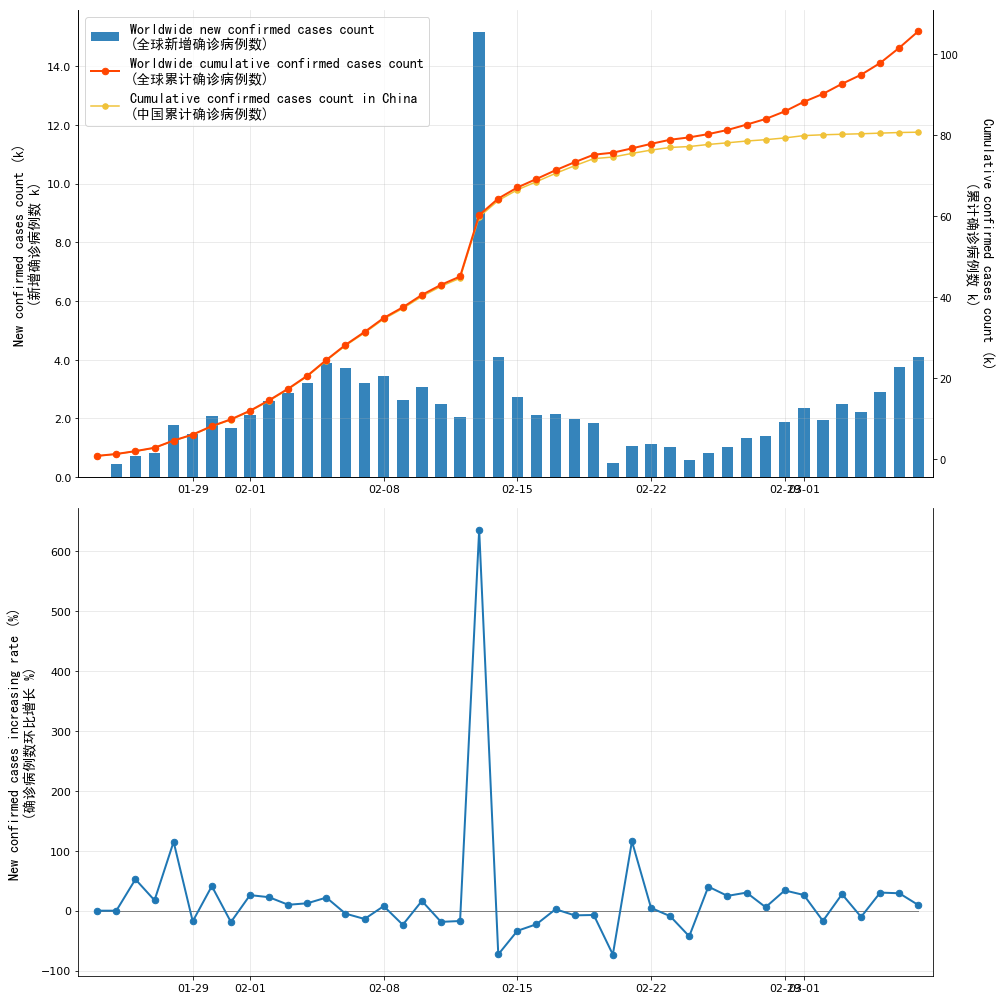

In [135]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

# above
bar_new_cfirmed = ax[0].bar(world_daily_df.index,
                            world_daily_df['country_confirmedCount_new'],
                            alpha=0.9,
                            width=0.6)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('New confirmed cases count (k)\n(新增确诊病例数 k)', size=12, fontproperties=fontP)
ax[0].yaxis.set_major_formatter(formatter_thousands_1dec)
ax[0].grid(which='major', alpha=0.3)
ax[0].spines['top'].set_visible(False)

ax_02 = ax[0].twinx()
line_cn_cfirmed, = ax_02.plot(country_daily_df[country_daily_df['countryName']=='China'].index,
                           country_daily_df[country_daily_df['countryName']=='China']['country_confirmedCount'],
                           color='#f0c239',#'#f0c239',e29c45
                           linewidth=1.5,
                           marker='.',
                           markersize=11)
line_cfirmed, = ax_02.plot(world_daily_df.index,
                           world_daily_df['country_confirmedCount'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.set_xticklabels(world_daily_df.index)
ax_02.set_ylabel('Cumulative confirmed cases count (k)\n(累计确诊病例数 k)', rotation=270,
                 labelpad=35, size=12, fontproperties=fontP)

ax_02.xaxis.set_major_formatter(DATESFMT)
ax_02.yaxis.set_major_formatter(formatter_thousands)

ax_02.legend(handles=(bar_new_cfirmed, line_cfirmed, line_cn_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('Worldwide new confirmed cases count\n(全球新增确诊病例数)',
                     'Worldwide cumulative confirmed cases count\n(全球累计确诊病例数)',
                     'Cumulative confirmed cases count in China\n(中国累计确诊病例数)'),
             loc=2)
ax_02.spines['top'].set_visible(False)

# below
ax[1].plot(world_daily_df.index,
           [0] * len(world_daily_df),
           color='gray', linewidth=1)
line_delta, = ax[1].plot(world_daily_df.index,
                         world_daily_df['country_confirmedCount_deltaRate'],
                         linewidth=2,
                         marker='.',
                         markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.3)
ax[1].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()



截至北京时间{{world_daily_df.index[-1].year}}年{{world_daily_df.index[-1].month}}月{{world_daily_df.index[-1].day}}日24时，全球累计确诊新冠肺炎病例约{{world_daily_df.loc[world_daily_df.index[-1], 'country_confirmedCount']}}例，较前一天增长{{int(world_daily_df.loc[world_daily_df.index[-1], 'country_confirmedCount_new'])}}例。

2020年2月13日，由于中国湖北省诊断标准更改，新增确诊数大大增加。按原有诊断标准，疑似病例且进行核酸/基因测序检查结果为阳性者被视为新增确诊病例；更改后的诊断标准添加了临床诊断病例，所谓临床诊断病例，是指疑似病例具有肺炎影像学特征者，也就是说，只要符合疑似标准，且有CT特征，即可被视为新增确诊病例，不再需要进行核酸检测。直至2月20日，全球每日新增确诊病例在逐日降低，但从2月21日起，每日新增确诊病例开始增加，且每日增长病例多余前一日。

--- English version ---

As of 24:00 Beijing time on {{world_daily_df.index[-1].day}}/{{world_daily_df.index[-1].month}}/{{world_daily_df.index[-1].year}}, there were about {{world_daily_df.loc[world_daily_df.index[-1], 'country_confirmedCount']}} cases of COVID-19, an increase of {{int(world_daily_df.loc[world_daily_df.index[-1], 'country_confirmedCount_new'])}} cases from the previous day.

On February 13, 2020, the number of newly confirmed cases increased significantly due to changes in diagnostic standards in Hubei Province. According to the original diagnostic criteria, suspected cases and positive results of nucleic acid / gene sequencing are considered as newly confirmed cases; the updated diagnostic criteria added clinical diagnosis cases. The so-called clinical diagnosis cases refer to the suspected cases with pneumonia imaging features, that is, as long as they meet the suspected criteria and have CT features, they can be regarded as newly confirmed cases, and no nucleic acid test is required.

### Actual confirmed count: China vs. Rest of World

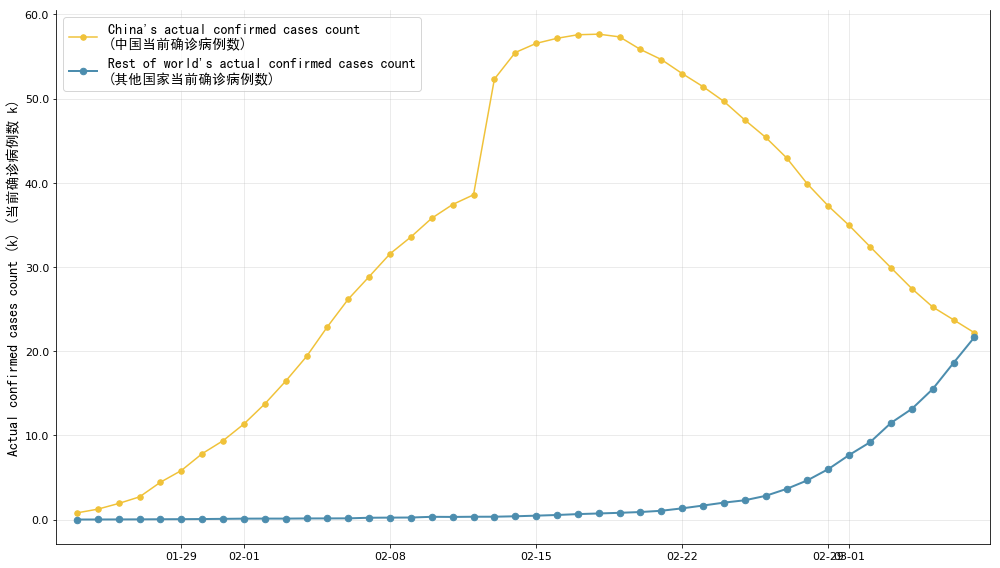

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

# above
line_cn_act_cfirmed, = ax.plot(country_daily_df[country_daily_df['countryName']=='China'].index,
                           country_daily_df[country_daily_df['countryName']=='China']['country_act_confirmedCount'],
                           color='#f0c239',#'#f0c239',e29c45
                           linewidth=1.5,
                           marker='.',
                           markersize=11)
line_row_act_cfirmed, = ax.plot(world_daily_df.index,
                                world_daily_df['country_act_confirmedCount']-country_daily_df[
                                    country_daily_df['countryName']=='China']['country_act_confirmedCount'],
                                color='#4c8dae',
                           linewidth=2,
                           marker='.',
                           markersize=13)

ax.tick_params(labelsize=11)
ax.set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax.xaxis.set_major_formatter(DATESFMT)

ax.set_ylabel('Actual confirmed cases count (k) (当前确诊病例数 k)', size=12, fontproperties=fontP)
ax.yaxis.set_major_formatter(formatter_thousands_1dec)
ax.grid(which='major', alpha=0.3)
ax.spines['top'].set_visible(False)

ax.legend(handles=(line_cn_act_cfirmed, line_row_act_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('China\'s actual confirmed cases count\n(中国当前确诊病例数)',
                     'Rest of world\'s actual confirmed cases count\n(其他国家当前确诊病例数)'),
             loc=2)

plt.tight_layout()
plt.show()



### Cured count vs. Dead count

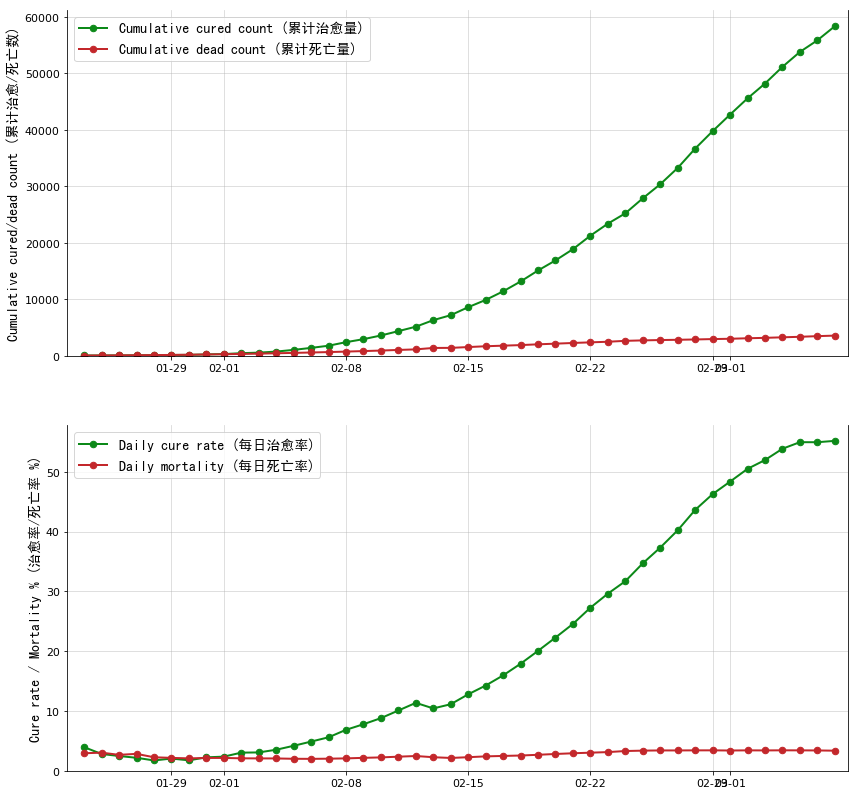

In [137]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

line_cured, = ax[0].plot(world_daily_df.index,
                      world_daily_df['country_curedCount'],
                      color='#0c8918', # green
                      linewidth=2,
                      marker='.',
                      markersize=13)

line_dead, = ax[0].plot(world_daily_df.index,
                     world_daily_df['country_deadCount'],
                     color='#c3272b', # red
                     linewidth=2,
                     marker='.',
                     markersize=13)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[0].set_ylim(bottom=0)
ax[0].set_ylabel('Cumulative cured/dead count (累计治愈/死亡数)', size=12, fontproperties=fontP)

ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].grid(which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax[0].legend(handles=(line_cured, line_dead),
             fontsize=13,
             prop=fontP,
             labels=('Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=2)

line_cure_rate, = ax[1].plot(world_daily_df.index,
                                 world_daily_df['cured_pct'],
                                 color='#0c8918',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)
line_mortality_pct, = ax[1].plot(world_daily_df.index,
                                 world_daily_df['mortality_pct'],
                                 color='#c3272b',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[1].set_ylim(bottom=0)
ax[1].set_ylabel('Cure rate / Mortality % (治愈率/死亡率 %)', size=12, fontproperties=fontP)

ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)

ax[1].legend(handles=(line_cure_rate, line_mortality_pct),
             fontsize=13,
             prop=fontP,
             labels=('Daily cure rate (每日治愈率)',
                     'Daily mortality (每日死亡率)'), loc=2)

plt.show()


截至北京时间{{world_daily_df.index[-1].year}}年{{world_daily_df.index[-1].month}}月{{world_daily_df.index[-1].day}}日24时，全球累计治愈新冠肺炎病例{{world_daily_df.loc[world_daily_df.index[-1], 'country_curedCount']}}例，累计死亡新冠肺炎病例{{world_daily_df.loc[world_daily_df.index[-1], 'country_deadCount']}}例。自2020年1月31日起，中国新冠肺炎病例治愈数量和治愈率超过死亡数量和死亡率，且差值越来越大，目前已达到{{round(world_daily_df.loc[world_daily_df.index[-1], 'cured_pct'], 2)}}%。这和医务人员的不懈努力是分不开的。

### Daily cumul nb of country with confirmed cases

In [138]:
daily_nb_coutry = country_daily_df[country_daily_df['country_confirmedCount']>0].groupby(
    country_daily_df[country_daily_df['country_confirmedCount']>0].index)['countryName'].nunique().reset_index()
daily_nb_coutry = daily_nb_coutry.rename(columns={'countryName':'countryNb'})

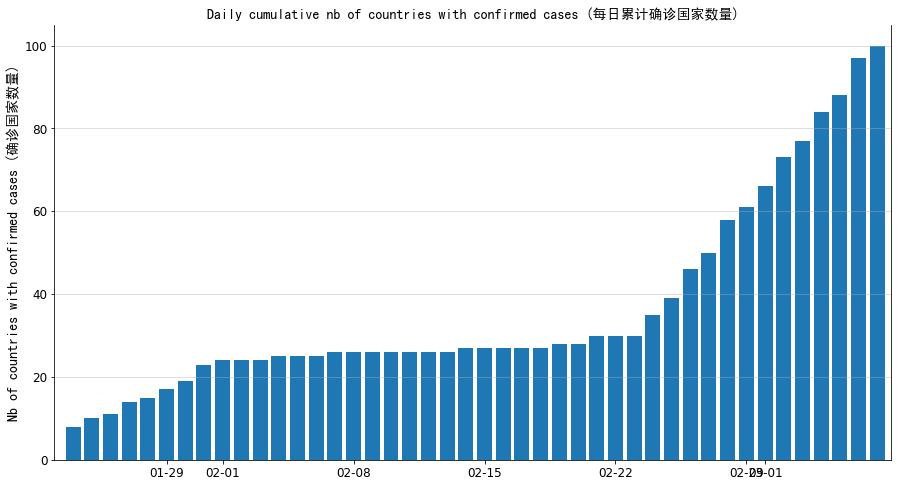

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.set_title('Daily cumulative nb of countries with confirmed cases (每日累计确诊国家数量)',
             fontdict={'fontsize': 14}, fontproperties=fontP)
ax.bar(daily_nb_coutry.Date_ymd,
       daily_nb_coutry.countryNb)
ax.tick_params(labelsize=12)
ax.set_xlim(left = date(2020, 1, 23), right=daily_nb_coutry.Date_ymd.max()+relativedelta(hours=18))
ax.set_ylabel('Nb of countries with confirmed cases (确诊国家数量)', fontproperties=fontP)
ax.xaxis.set_major_formatter(DATESFMT)

ax.spines['top'].set_visible(False)
ax.grid(axis='y', which='major', alpha=0.5)

# plt.show()
# plt.savefig('20200302_countries_population.png', bbox_inches='tight')


### Cumulative confirmed count per country & confirmed cases per 1000 persons

In [140]:
country_last_df = country_daily_df[country_daily_df.index == country_daily_df.index.max()]

country_last_sorted_df = country_last_df.copy()
country_last_sorted_df = country_last_sorted_df.sort_values(by='country_act_confirmedCount',
                                                            ascending=False).reset_index(drop=True)

country_last_sorted_df = pd.merge(country_last_sorted_df,
                                 world_pop19_df,
                                 on='countryName', how='left')
country_last_sorted_df = country_last_sorted_df.fillna(0)

country_last_sorted_df['country_confirmedCount_per1000person'] = country_last_sorted_df['country_confirmedCount'] / country_last_sorted_df['population2019_k']


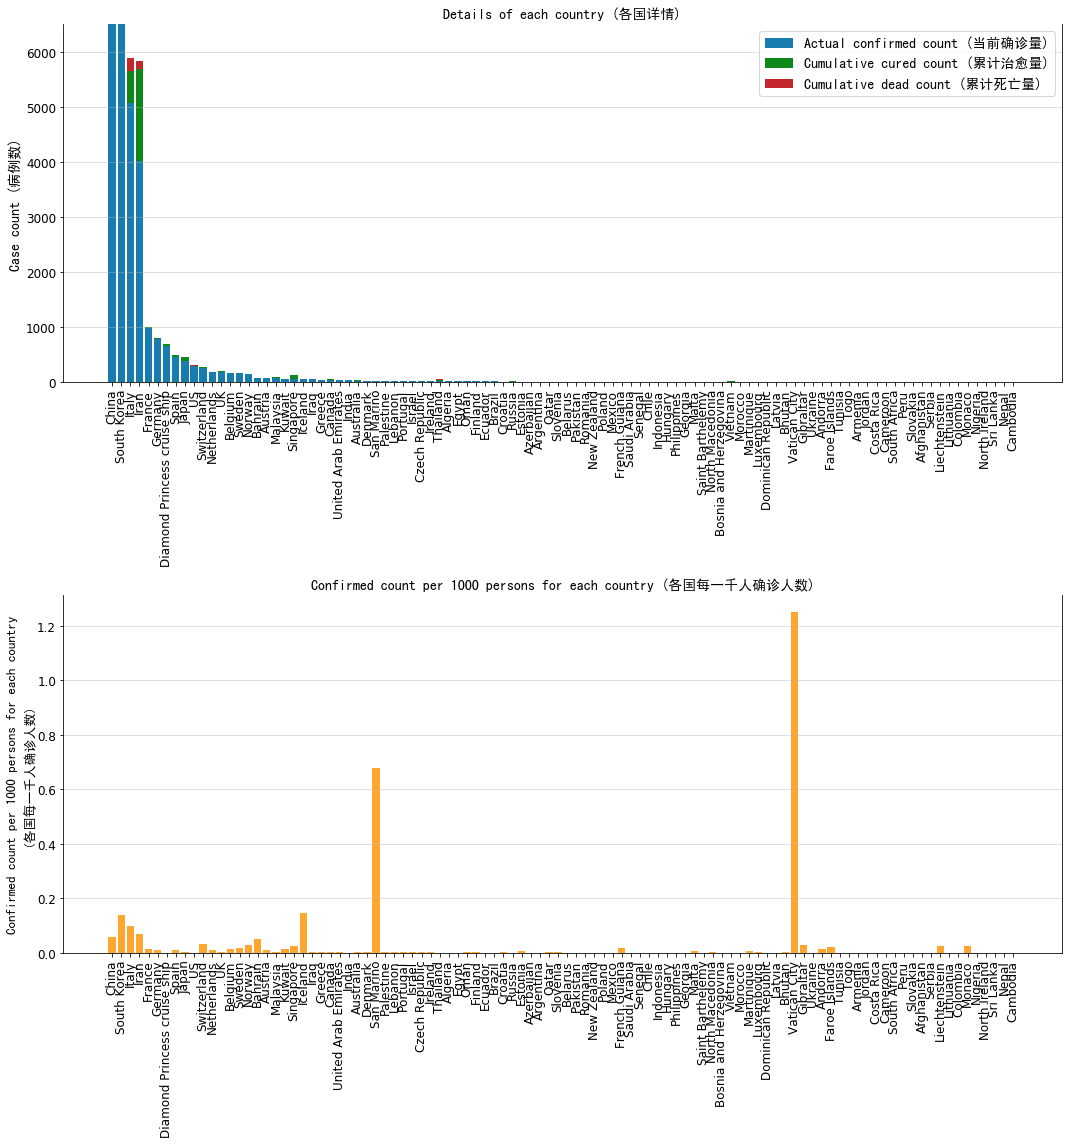

In [141]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# above
ax[0].set_title('Details of each country (各国详情)', fontdict={'fontsize': 14}, fontproperties=fontP)
rect11 = ax[0].bar(country_last_sorted_df.countryName,
                   country_last_sorted_df.country_act_confirmedCount,
                   color='#177cb0')
rect12 = ax[0].bar(country_last_sorted_df.countryName,
                   country_last_sorted_df.country_curedCount,
                   bottom=country_last_sorted_df.country_act_confirmedCount,
                   color='#0c8918')
rect13 = ax[0].bar(country_last_sorted_df.countryName,
                   country_last_sorted_df.country_deadCount,
                   bottom=country_last_sorted_df.country_act_confirmedCount + country_last_sorted_df.country_curedCount,
                   color='#c3272b')

ax[0].tick_params(labelsize=12)
# ax[0].set_xlim(left=-0.5, right=20)
ax[0].set_xticklabels(country_last_sorted_df.countryName, rotation=90)
ax[0].set_ylabel('Case count (病例数)', fontproperties=fontP)
ax[0].set_ylim(top=6500)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', which='major', alpha=0.5)

ax[0].legend(handles=(rect11, rect12, rect13),
             prop=fontP,
             labels=('Actual confirmed count (当前确诊量)',
                     'Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=1)

# below
ax[1].set_title('Confirmed count per 1000 persons for each country (各国每一千人确诊人数)',
                fontdict={'fontsize': 14}, fontproperties=fontP)
ax[1].bar(country_last_sorted_df.countryName,
          country_last_sorted_df.country_confirmedCount_per1000person,
          color='#ffa631')

ax[1].tick_params(labelsize=12)
ax[1].set_xticklabels(country_last_sorted_df.countryName, rotation=90)
ax[1].set_ylabel('Confirmed count per 1000 persons for each country\n(各国每一千人确诊人数)',
                 size=12, fontproperties=fontP_medium)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', which='major', alpha=0.5)

plt.tight_layout()
# plt.subplots_adjust(hspace=0.45)
# plt.show()
# plt.savefig('20200302_countries_population.png', bbox_inches='tight')


上图国家按照现存确诊数降序排列。现存确诊病例最多的三个国家为{{country_last_sorted_df.loc[0, 'countryName']}}、{{country_last_sorted_df.loc[1, 'countryName']}}和{{country_last_sorted_df.loc[2, 'countryName']}}，分别有{{int(country_last_sorted_df.loc[0, 'country_act_confirmedCount'])}}例、{{int(country_last_sorted_df.loc[1, 'country_act_confirmedCount'])}}例和{{int(country_last_sorted_df.loc[2, 'country_act_confirmedCount'])}}例。虽然中国累计确诊病例远超韩国，但结合2019年人口总数比较，每千人的确诊病例数韩国位居第一位，这可能与人们重视程度有关。

The countries in the figure above are listed in descending order of the number of confirmed diagnoses. The three countries with the highest number of confirmed cases are {{country_last_sorted_df.loc [0, 'countryName']}}, {{country_last_sorted_df.loc [1, 'countryName']}}, and {{country_last_sorted_df.loc [2, 'countryName' ]}}, with {{int (country_last_sorted_df.loc [0, 'country_act_confirmedCount'])}}, {{int (country_last_sorted_df.loc [1, 'country_act_confirmedCount'])}}, and {{int (country_last_sorted_df. loc [2, 'country_act_confirmedCount'])}}, respectively. Although China has far more confirmed cases than Korea, combined with the total population in 2019, Korea ranks first in the number of confirmed cases per 1,000 people, which may be related to people's attention.



### Daily cumulative confirmed count for each country

In [142]:
country_daily_cfirmed_pvt = pd.pivot_table(data=country_daily_df,
                                           columns=country_daily_df.index,
                                           index='countryName',
                                           values='country_confirmedCount')
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.sort_values(by=country_daily_cfirmed_pvt.columns[-1],
                                                                  ascending=False)


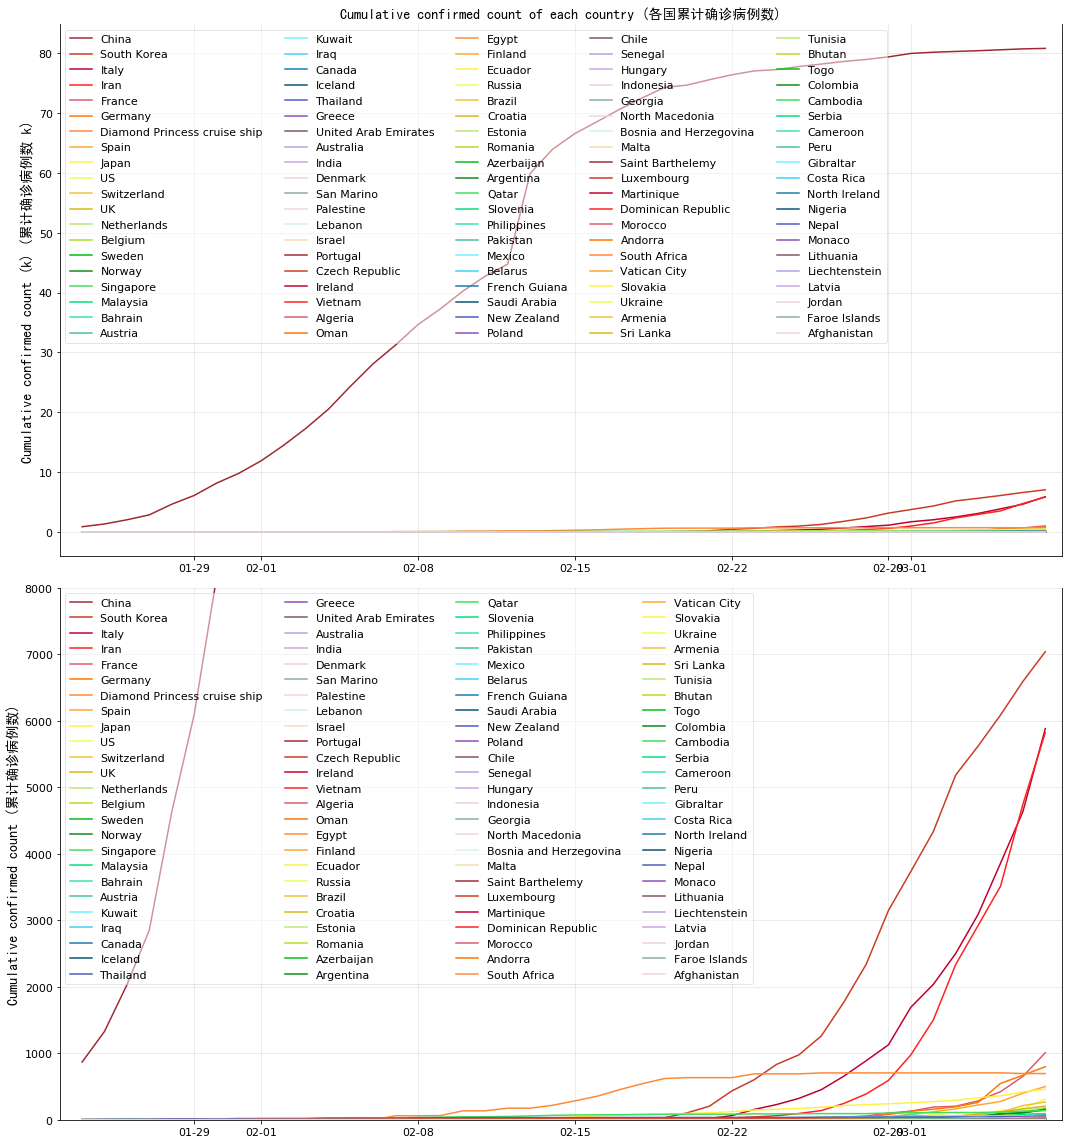

In [143]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Cumulative confirmed count of each provinces
ax[0].set_title('Cumulative confirmed count of each country (各国累计确诊病例数)',
                fontdict={'fontsize': 14}, fontproperties=fontP)

ax[0].set_prop_cycle(color=province_colors)
for city, d in country_daily_cfirmed_pvt.iterrows():
    ax[0].plot(d.index, d, label=city)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('Cumulative confirmed count (k) (累计确诊病例数 k)', fontproperties=fontP)
ax[0].spines['top'].set_visible(False)
ax[0].grid(which='major', alpha=0.3)
ax[0].legend(loc=2, ncol=5, fontsize=11, framealpha=0.5)
ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].yaxis.set_major_formatter(formatter_thousands)

ax[1].set_prop_cycle(color=province_colors)
for city, d in country_daily_cfirmed_pvt.iterrows():
    ax[1].plot(d.index, d, label=city)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=china_daily_last.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('Cumulative confirmed count (累计确诊病例数)', fontproperties=fontP)
ax[1].set_ylim(bottom=0, top=8000)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].spines['top'].set_visible(False)
ax[1].grid(which='major', alpha=0.3)
ax[1].legend(loc=2, ncol=4, fontsize=11, framealpha=0.5)

plt.tight_layout()
# plt.show()
# plt.savefig('20200302_countries_ts.png', bbox_inches='tight')

In [144]:
# country_daily_cfirmed_pvt.to_csv('country_daily_cfirmed_pvt.csv')

In [145]:
country_daily_cfirmed_pvt.head()

Date_ymd     2020-01-24  2020-01-25  2020-01-26  2020-01-27  2020-01-28  \
countryName                                                               
China               868        1329        2029        2853        4627   
South Korea           2           2           3           4           4   
Italy                 0           0           0           0           0   
Iran                  0           0           0           0           0   
France                2           2           3           3           4   

Date_ymd     2020-01-29  2020-01-30  2020-01-31  2020-02-01  2020-02-02  ...  \
countryName                                                              ...   
China              6090        8148        9808       11901       14489  ...   
South Korea           4           4          11          12          15  ...   
Italy                 0           0           2           2           2  ...   
Iran                  0           0           0           0           0  ...   
France                5           6           6           6           6  ...   

Date_ymd     2020-02-27  2020-02-28  2020-02-29  2020-03-01  2020-03-02  \
countryName                                                               
China             78631       78962       79395       79972       80175   
South Korea        1766        2337        3150        3736        4335   
Italy               655         888        1128        1694        2036   
Iran                245         388         593         978        1501   
France               38          57         100         130         191   

Date_ymd     2020-03-03  2020-03-04  2020-03-05  2020-03-06  2020-03-07  
countryName                                                              
China             80303       80424       80581       80734       80815  
South Korea        5186        5621        6088        6593        7041  
Italy              2502        3089        3858        4636        5883  
Iran               2336        2922        3513        4747        5823  
France              204         285         423         653        1009  

[5 rows x 44 columns]

In [146]:
country_daily_cfirmed_evol = pd.DataFrame(index=country_daily_cfirmed_pvt.columns)

for i, rows in country_daily_cfirmed_pvt.iterrows():
    country_daily_cfirmed_evol = pd.concat([country_daily_cfirmed_evol,
                                            country_daily_cfirmed_pvt.loc[i].pct_change() * 100],
                                           axis='columns')    

country_daily_cfirmed_evol = country_daily_cfirmed_evol.fillna(0)
country_daily_cfirmed_evol = country_daily_cfirmed_evol.T

In [191]:
for ctry, rows in country_daily_cfirmed_evol.iterrows():
    for col in country_daily_cfirmed_evol.columns:
        if rows[col]==float('Inf'):
            country_daily_cfirmed_evol.loc[ctry, col] = country_daily_cfirmed_pvt.loc[ctry, col]
        else:
            pass
        

In [147]:
# country_daily_actCfirmed_pvt = pd.pivot_table(data=country_daily_df,
#                                            columns=country_daily_df.index,
#                                            index='countryName',
#                                            values='country_act_confirmedCount')
# country_daily_actCfirmed_pvt = country_daily_actCfirmed_pvt.sort_values(by=country_daily_actCfirmed_pvt.columns[-2],
#                                                                   ascending=False)

# country_daily_actCfirmed_evol = pd.DataFrame(index=country_daily_actCfirmed_pvt.columns)

# for i, rows in country_daily_actCfirmed_pvt.iterrows():
#     country_daily_actCfirmed_evol = pd.concat([country_daily_actCfirmed_evol,
#                                             country_daily_actCfirmed_pvt.loc[i].pct_change() * 100],
#                                            axis='columns')    

# country_daily_actCfirmed_evol = country_daily_actCfirmed_evol.fillna(0)
# country_daily_actCfirmed_evol = country_daily_actCfirmed_evol.T

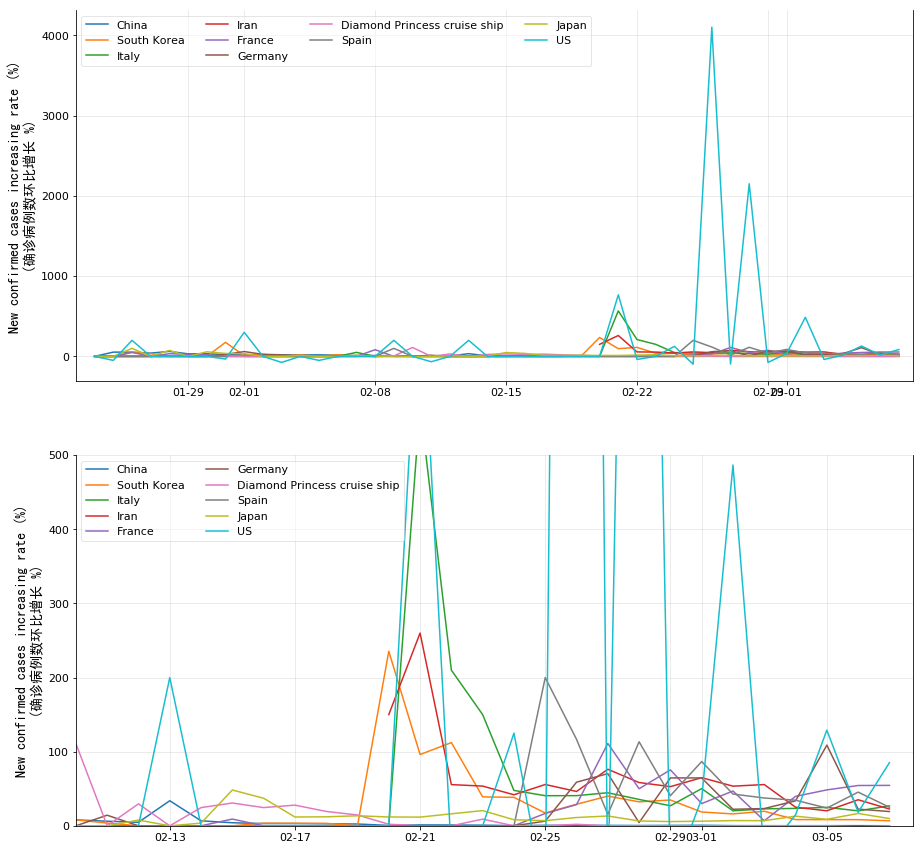

In [148]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# ax.set_prop_cycle(color=province_colors)
for country, d in country_daily_cfirmed_evol.iloc[:10].iterrows():
    ax[0].plot(d.index, d, label=country)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[0].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].grid(which='major', alpha=0.3)
ax[0].spines['top'].set_visible(False)
ax[0].legend(loc=2, ncol=4, fontsize=11, framealpha=0.5)

for country, d in country_daily_cfirmed_evol.iloc[:10].iterrows():
    ax[1].plot(d.index, d, label=country)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 2, 10), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[1].set_ylim(bottom=0, top=500)
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.3)
ax[1].spines['top'].set_visible(False)
ax[1].legend(ncol=2, fontsize=11, framealpha=0.5)


plt.show()
# plt.savefig('20200301_countries_top10.png', bbox_inches='tight')

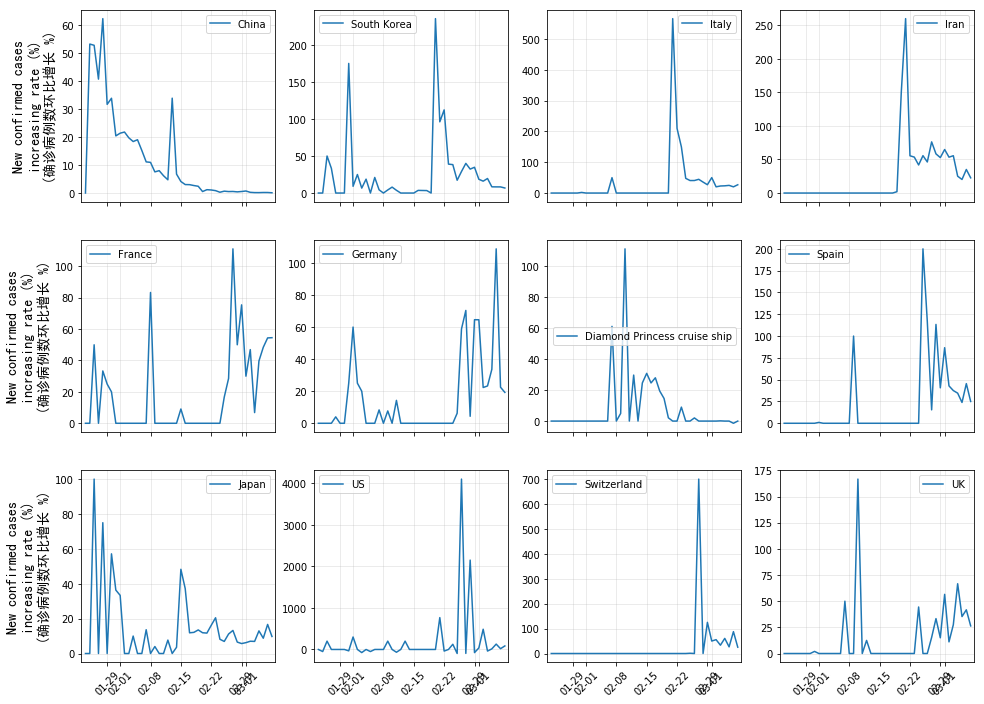

In [193]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), sharex=True)

ax[0, 0].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 0],
              label=country_daily_cfirmed_evol.T.columns[0])
ax[0, 1].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 1],
              label=country_daily_cfirmed_evol.T.columns[1])
ax[0, 2].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 2],
              label=country_daily_cfirmed_evol.T.columns[2])
ax[0, 3].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 3],
              label=country_daily_cfirmed_evol.T.columns[3])
ax[1, 0].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 4],
              label=country_daily_cfirmed_evol.T.columns[4])
ax[1, 1].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 5],
              label=country_daily_cfirmed_evol.T.columns[5])
ax[1, 2].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 6],
              label=country_daily_cfirmed_evol.T.columns[6])
ax[1, 3].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 7],
              label=country_daily_cfirmed_evol.T.columns[7])
ax[2, 0].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 8],
              label=country_daily_cfirmed_evol.T.columns[8])
ax[2, 1].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 9],
              label=country_daily_cfirmed_evol.T.columns[9])
ax[2, 2].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 10],
              label=country_daily_cfirmed_evol.T.columns[10])
ax[2, 3].plot(country_daily_cfirmed_evol.T.index,
              country_daily_cfirmed_evol.T.iloc[:, 11],
              label=country_daily_cfirmed_evol.T.columns[11])

ax[2, 0].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[2, 0].set_xticklabels(country_daily_cfirmed_evol.T.index, rotation=45)
ax[2, 0].xaxis.set_major_formatter(DATESFMT)

ax[2, 1].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[2, 1].set_xticklabels(country_daily_cfirmed_evol.T.index, rotation=45)
ax[2, 1].xaxis.set_major_formatter(DATESFMT)

ax[2, 2].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[2, 2].set_xticklabels(country_daily_cfirmed_evol.T.index, rotation=45)
ax[2, 2].xaxis.set_major_formatter(DATESFMT)

ax[2, 3].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[2, 3].set_xticklabels(country_daily_cfirmed_evol.T.index, rotation=45)
ax[2, 3].xaxis.set_major_formatter(DATESFMT)

ax[0, 0].set_ylabel('New confirmed cases\nincreasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1, 0].set_ylabel('New confirmed cases\nincreasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[2, 0].set_ylabel('New confirmed cases\nincreasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)

ax[0, 0].grid(which='major', alpha=0.3)
ax[0, 1].grid(which='major', alpha=0.3)
ax[0, 2].grid(which='major', alpha=0.3)
ax[0, 3].grid(which='major', alpha=0.3)
ax[1, 0].grid(which='major', alpha=0.3)
ax[1, 1].grid(which='major', alpha=0.3)
ax[1, 2].grid(which='major', alpha=0.3)
ax[1, 3].grid(which='major', alpha=0.3)
ax[2, 0].grid(which='major', alpha=0.3)
ax[2, 1].grid(which='major', alpha=0.3)
ax[2, 2].grid(which='major', alpha=0.3)
ax[2, 3].grid(which='major', alpha=0.3)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 2].legend()
ax[0, 3].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[1, 2].legend()
ax[1, 3].legend()
ax[2, 0].legend()
ax[2, 1].legend()
ax[2, 2].legend()
ax[2, 3].legend()

# plt.savefig('20200302_countries_top12_evol.png', bbox_inches='tight')

对于累计确诊病例最多的12个国家，上图描绘了各国确诊病例环比增长的百分比。其中韩国2月20日新增确诊病例较前一日增加例2倍多，意大利2月21日的新增确诊病例较前一日增加了5倍，法国2月25日的新增确诊病例较前一日增加了1倍有余。

For the top 12 countries with the highest number of confirmed cases, the chart above describes the percentage increase in the number of confirmed cases. Among them, the number of newly confirmed cases in South Korea on February 20 increased more than twice over the previous day, the number of newly confirmed cases in Italy on February 21 increased five times compared to the previous day, and the number of newly confirmed cases in France on February 25 was once more than the previous day.

### Simulation of France with Italy, Germany, Spain & Switzerland's data

In [205]:
fr_simul_df = country_daily_df[country_daily_df['countryName'] == 'France']

fr_simul_df = pd.merge(fr_simul_df, country_daily_cfirmed_evol.T['France'], left_index=True, right_index=True)
fr_simul_df = pd.merge(fr_simul_df, country_daily_cfirmed_evol.T['Italy'], left_index=True, right_index=True)
fr_simul_df = pd.merge(fr_simul_df, country_daily_cfirmed_evol.T['Switzerland'], left_index=True, right_index=True)
fr_simul_df = pd.merge(fr_simul_df, country_daily_cfirmed_evol.T['Spain'], left_index=True, right_index=True)
fr_simul_df = pd.merge(fr_simul_df, country_daily_cfirmed_evol.T['Germany'], left_index=True, right_index=True)

fr_simul_df = fr_simul_df.rename(columns={'France':'cfirmed_evol_fr',
                                          'Italy':'cfirmed_evol_it',
                                          'Switzerland':'cfirmed_evol_ch',
                                          'Spain':'cfirmed_evol_es',
                                          'Germany':'cfirmed_evol_de'})

for d, rows in fr_simul_df.iterrows():
    if d == fr_simul_df.index[0]:
        fr_simul_df.loc[d, 'simul_it'] = rows['country_confirmedCount']
        fr_simul_df.loc[d, 'simul_de'] = rows['country_confirmedCount']
        fr_simul_df.loc[d, 'simul_es'] = rows['country_confirmedCount']
        fr_simul_df.loc[d, 'simul_ch'] = rows['country_confirmedCount']
    else:
        fr_simul_df.loc[d, 'simul_it'] = \
        fr_simul_df.loc[d+relativedelta(days=-1), 'simul_it'] * (1 + rows['cfirmed_evol_it']/100)
        fr_simul_df.loc[d, 'simul_de'] = \
        fr_simul_df.loc[d+relativedelta(days=-1), 'simul_de'] * (1 + rows['cfirmed_evol_de']/100)
        fr_simul_df.loc[d, 'simul_es'] = \
        fr_simul_df.loc[d+relativedelta(days=-1), 'simul_es'] * (1 + rows['cfirmed_evol_es']/100)
        fr_simul_df.loc[d, 'simul_ch'] = \
        fr_simul_df.loc[d+relativedelta(days=-1), 'simul_ch'] * (1 + rows['cfirmed_evol_ch']/100)

fr_simul_df.tail()


countryName  country_confirmedCount  country_curedCount  \
Date_ymd                                                             
2020-03-03      France                     204                  12   
2020-03-04      France                     285                  12   
2020-03-05      France                     423                  12   
2020-03-06      France                     653                  12   
2020-03-07      France                    1009                  12   

            country_deadCount  mortality_pct  cured_pct  \
Date_ymd                                                  
2020-03-03                  4       1.960784   5.882353   
2020-03-04                  4       1.403509   4.210526   
2020-03-05                  6       1.418440   2.836879   
2020-03-06                  9       1.378254   1.837672   
2020-03-07                 11       1.090188   1.189296   

            country_act_confirmedCount  cfirmed_evol_fr  cfirmed_evol_it  \
Date_ymd                                                                   
2020-03-03                         188         6.806283        22.888016   
2020-03-04                         269        39.705882        23.461231   
2020-03-05                         405        48.421053        24.894788   
2020-03-06                         632        54.373522        20.165889   
2020-03-07                         986        54.517611        26.898188   

            cfirmed_evol_ch  cfirmed_evol_es  cfirmed_evol_de  simul_it  \
Date_ymd                                                                  
2020-03-03        33.333333        37.500000        23.270440   2552.04   
2020-03-04        60.714286        34.545455        33.673469   3150.78   
2020-03-05        26.666667        23.873874       108.778626   3935.16   
2020-03-06        87.719298        45.454545        22.486289   4728.72   
2020-03-07        25.233645        25.000000        19.253731   6000.66   

            simul_de  simul_es  simul_ch  
Date_ymd                                  
2020-03-03    101.92    333.30    113.12  
2020-03-04    136.24    448.44    181.80  
2020-03-05    284.44    555.50    230.28  
2020-03-06    348.40    808.00    432.28  
2020-03-07    415.48   1010.00    541.36

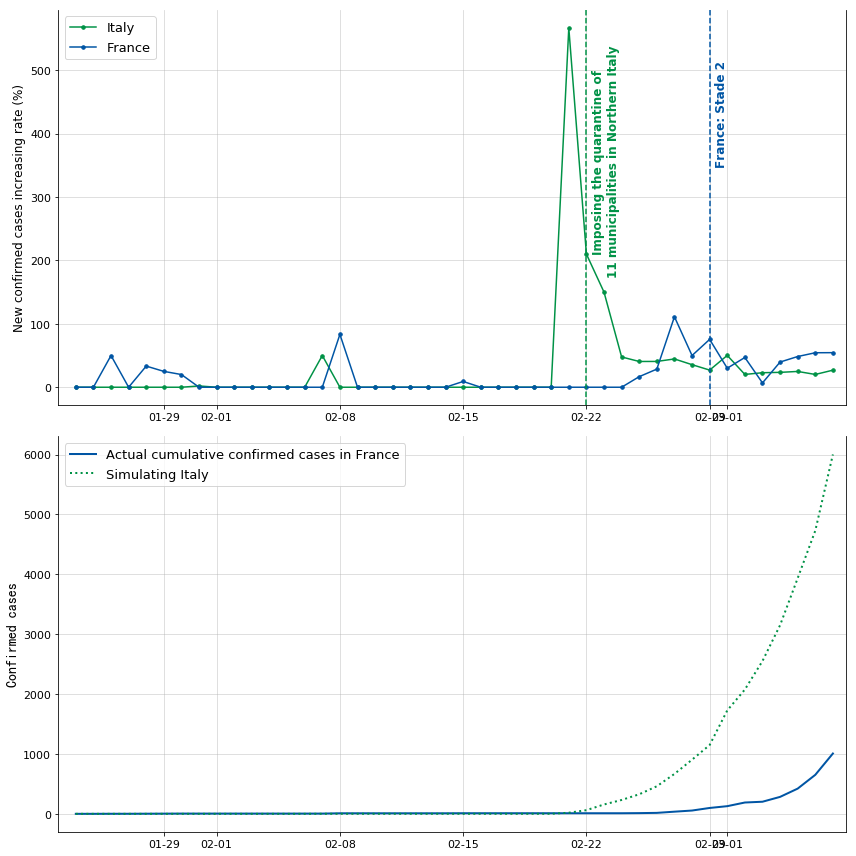

In [252]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

line_evol_it, = ax[0].plot(fr_simul_df.index,
                      fr_simul_df['cfirmed_evol_it'],
                      color='#009246',
                      linewidth=1.5,
                      marker='.',
                      markersize=7)

line_evol_fr, = ax[0].plot(fr_simul_df.index,
                     fr_simul_df['cfirmed_evol_fr'],
                     color='#0055a4',
                      linewidth=1.5,
                      marker='.',
                      markersize=7)

ax[0].tick_params(labelsize=11)
ax[0].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
# ax[0].set_ylim(bottom=0, top=200)
ax[0].set_ylabel('New confirmed cases increasing rate (%)',
                 size=12)

ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].grid(which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax[0].legend(handles=(line_evol_it, line_evol_fr),
             fontsize=13,
             labels=('Italy', 'France'), loc=2)

ax[0].axvline(x=fr_daily_df.index[29], color='#009246', linestyle='--')
ax[0].axvline(x=fr_daily_df.index[36], color='#0055a4', linestyle='--')
ax[0].text(x=fr_daily_df.index[29]+relativedelta(hours=7),
           y=500,
           color='#009246',
           multialignment='center',
           fontweight='semibold',
           s='Imposing the quarantine of\n11 municipalities in Northern Italy',
           fontsize=12,
           rotation=90)
ax[0].text(x=fr_daily_df.index[36]+relativedelta(hours=7),
           y=500,
           color='#0055a4',
           multialignment='center',
           fontweight='semibold',
           s='France: Stade 2',
           fontsize=12,
           rotation=90)


line_actual_fr, = ax[1].plot(fr_simul_df.index,
                             fr_simul_df['country_confirmedCount'],
                             color='#0055a4',
                             linewidth=2)
line_fr_simul_it, = ax[1].plot(fr_simul_df.index,
                               fr_simul_df['simul_it'],
                               ':',
                               color='#009246',
                               linewidth=2)

ax[1].tick_params(labelsize=11)
ax[1].set_xlim(left = date(2020, 1, 23), right=world_daily_df.index.max()+relativedelta(hours=18))
ax[1].set_ylabel('Confirmed cases', size=12, fontproperties=fontP)

ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)

ax[1].legend(handles=(line_actual_fr, line_fr_simul_it),
             fontsize=13,
             labels=('Actual cumulative confirmed cases in France',
                     'Simulating Italy'), loc=2)

plt.tight_layout()
# plt.show()
# plt.savefig('20200307_france_simul_italy.png', bbox_inches='tight')


### Predict France's cumulative confirmed count with evolution after 24/02/2020

In [243]:
fr_simul_df['confirmedCount_evol'] = fr_simul_df['country_confirmedCount'].pct_change()
fr_simul_df['confirmedCount_evol'] = fr_simul_df['confirmedCount_evol'].fillna(0)

In [244]:
fr_simul_df.loc[date(2020, 2, 24):, 'confirmedCount_evol'].mean()
# 0.42334801660764443 (20200306)
# 0.43271940842708234 (20200307)

0.43271940842708234

In [245]:
fr_predict_df = pd.DataFrame(index=pd.date_range(date(2020, 1, 24),
                                                 (datetime.now() + relativedelta(days=7)).date()))
fr_predict_df = pd.merge(fr_predict_df,
                         fr_simul_df[['country_confirmedCount']],
                         left_index=True,
                         right_index=True,
                         how='left')

for d, nb in fr_predict_df.iterrows():
    if math.isnan(nb):
        fr_predict_df.loc[d, 'country_confirmedCount'] = fr_predict_df.loc[d-1, 'country_confirmedCount'] * (
            1 + fr_simul_df.loc[date(2020, 2, 24):, 'confirmedCount_evol'].mean())
    else:
        pass


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  if sys.path[0] == '':


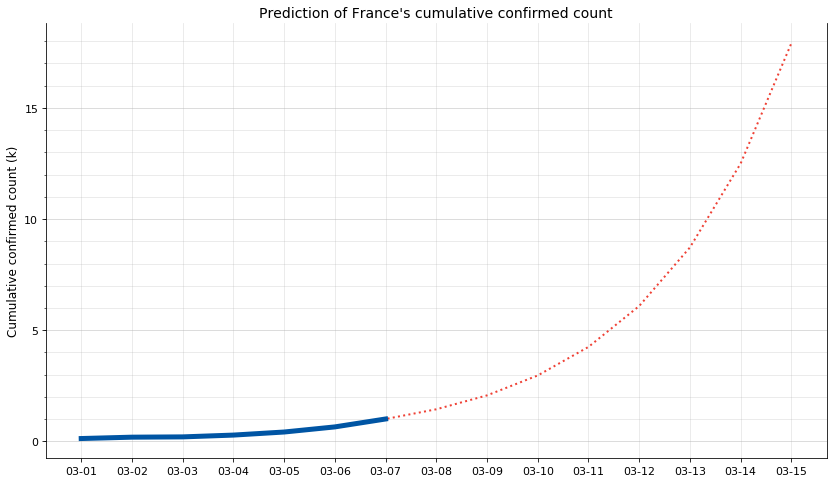

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

ax.set_title('Prediction of France\'s cumulative confirmed count',
                fontdict={'fontsize': 14})
line_pred, = ax.plot(fr_predict_df.loc[date(2020, 3, 1):].index,
                     fr_predict_df.loc[date(2020, 3, 1):].country_confirmedCount,
                     color='#EF4135',
                     linestyle=':',
                     linewidth=2)
line_actual, = ax.plot(fr_simul_df.loc[date(2020, 3, 1):].index,
                       fr_simul_df.loc[date(2020, 3, 1):]['country_confirmedCount'],
                       color='#0055a4',
                       linewidth=5)

ax.tick_params(labelsize=11)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.set_xticks(fr_predict_df.loc[date(2020, 3, 1):].index)
ax.set_yticks(range(0, 18001, 1000))
ax.set_ylabel('Cumulative confirmed count (k)', size=12)

ax.xaxis.set_major_formatter(DATESFMT)
ax.yaxis.set_major_formatter(formatter_thousands)
ax.yaxis.set_major_locator(MultipleLocator(5000))
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.grid(which='both', alpha=0.3)
ax.spines['top'].set_visible(False)

# plt.tight_layout()
# plt.show()
# plt.savefig('20200307_france_prediction.png', bbox_inches='tight')


In [325]:
fr_predict_df.tail(10)

country_confirmedCount
2020-03-06              653.000000
2020-03-07             1009.000000
2020-03-08             1445.613883
2020-03-09             2071.159067
2020-03-10             2967.389794
2020-03-11             4251.436950
2020-03-12             6091.116232
2020-03-13             8726.860444
2020-03-14            12503.142333
2020-03-15            17913.494687

### Predicting with Italy's speed

In [296]:
fr_daily_cfirmed = country_daily_cfirmed_pvt.T['France'].to_frame()
fr_daily_cfirmed = pd.merge(fr_daily_cfirmed, country_daily_cfirmed_evol.T['France'],
                            left_index=True, right_index=True, suffixes=('_nb', '_evol'))

it_daily_cfirmed = country_daily_cfirmed_pvt.T['Italy'].to_frame()
it_daily_cfirmed = pd.merge(it_daily_cfirmed, country_daily_cfirmed_evol.T['Italy'],
                            left_index=True, right_index=True, suffixes=('_nb', '_evol'))

France_nb  France_evol
Date_ymd                          
2020-01-24          2     0.000000
2020-01-25          2     0.000000
2020-01-26          3    50.000000
2020-01-27          3     0.000000
2020-01-28          4    33.333333
2020-01-29          5    25.000000
2020-01-30          6    20.000000
2020-01-31          6     0.000000
2020-02-01          6     0.000000
2020-02-02          6     0.000000
2020-02-03          6     0.000000
2020-02-04          6     0.000000
2020-02-05          6     0.000000
2020-02-06          6     0.000000
2020-02-07          6     0.000000
2020-02-08         11    83.333333
2020-02-09         11     0.000000
2020-02-10         11     0.000000
2020-02-11         11     0.000000
2020-02-12         11     0.000000
2020-02-13         11     0.000000
2020-02-14         11     0.000000
2020-02-15         12     9.090909
2020-02-16         12     0.000000
2020-02-17         12     0.000000
2020-02-18         12     0.000000
2020-02-19         12     0.000000
2020-02-20         12     0.000000
2020-02-21         12     0.000000
2020-02-22         12     0.000000
2020-02-23         12     0.000000
2020-02-24         12     0.000000
2020-02-25         14    16.666667
2020-02-26         18    28.571429
2020-02-27         38   111.111111
2020-02-28         57    50.000000
2020-02-29        100    75.438596
2020-03-01        130    30.000000
2020-03-02        191    46.923077
2020-03-03        204     6.806283
2020-03-04        285    39.705882
2020-03-05        423    48.421053
2020-03-06        653    54.373522
2020-03-07       1009    54.517611

In [303]:
it_evol_before = it_daily_cfirmed[it_daily_cfirmed['Italy_nb'] <= country_daily_cfirmed_pvt.T['France'][-1]]['Italy_evol'].mean()
it_evol_after = it_daily_cfirmed[it_daily_cfirmed['Italy_nb'] > country_daily_cfirmed_pvt.T['France'][-1]]['Italy_evol'].mean()
it_r = it_evol_before/it_evol_after

fr_pred_evol = fr_daily_cfirmed['France_evol'].mean() / it_r
fr_pred_daynb = len(it_daily_cfirmed[it_daily_cfirmed['Italy_nb'] > country_daily_cfirmed_pvt.T['France'][-1]])

In [322]:
it_r

1.2237777826004912

In [310]:
fr_pred_evol

14.546847880865583

In [311]:
fr_pred_daynb

8

In [317]:
fr_pred_with_it = pd.DataFrame(index=pd.date_range(date(2020, 1, 24),
                                                 (datetime.now() + relativedelta(days=fr_pred_daynb-1)).date()))
fr_pred_with_it.index
fr_pred_with_it = pd.merge(fr_pred_with_it,
                         fr_simul_df[['country_confirmedCount']],
                         left_index=True,
                         right_index=True,
                         how='left')

for d, nb in fr_pred_with_it.iterrows():
    if math.isnan(nb):
        fr_pred_with_it.loc[d, 'country_confirmedCount'] = \
        fr_pred_with_it.loc[d-1, 'country_confirmedCount'] * (1 + fr_pred_evol/100)
    else:
        pass

fr_pred_with_it.tail()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  del sys.path[0]


country_confirmedCount
2020-03-11             1737.095667
2020-03-12             1989.788331
2020-03-13             2279.239813
2020-03-14             2610.797362
2020-03-15             2990.586082

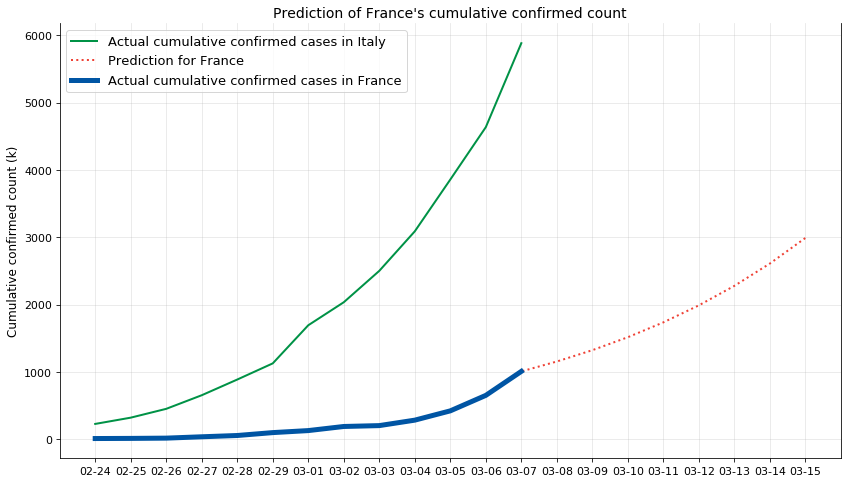

In [329]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

ax.set_title('Prediction of France\'s cumulative confirmed count',
                fontdict={'fontsize': 14})
line_it, = ax.plot(it_daily_cfirmed.loc[date(2020, 2, 24):].index,
                     it_daily_cfirmed.loc[date(2020, 2, 24):]['Italy_nb'],
                     color='#009246',
#                      linestyle=':',
                     linewidth=2)
line_fr_pred, = ax.plot(fr_pred_with_it.loc[date(2020, 2, 24):].index,
                     fr_pred_with_it.loc[date(2020, 2, 24):]['country_confirmedCount'],
                     color='#EF4135',
                     linestyle=':',
                     linewidth=2)
line_fr, = ax.plot(fr_simul_df.loc[date(2020, 2, 24):].index,
                       fr_simul_df.loc[date(2020, 2, 24):]['country_confirmedCount'],
                       color='#0055a4',
                       linewidth=5)



ax.tick_params(labelsize=11)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.set_xticks(fr_pred_with_it.loc[date(2020, 2, 24):].index)
ax.set_ylabel('Cumulative confirmed count (k)', size=12)

ax.xaxis.set_major_formatter(DATESFMT)
ax.grid(which='both', alpha=0.3)
ax.spines['top'].set_visible(False)

ax.legend(handles=(line_it, line_fr_pred, line_fr),
             fontsize=13,
             labels=('Actual cumulative confirmed cases in Italy',
                     'Prediction for France',
                     'Actual cumulative confirmed cases in France'), loc=2)
# plt.tight_layout()
# plt.show()
# plt.savefig('20200307_france_prediction.png', bbox_inches='tight')
